<p style="font-size:20px; text-align:center">CS6910 - Assignment 1</p>
<!-- <p style="font-size:18px; text-align:center">CS6910: Fundamentals of Deep Learning</p> -->

<p style="font-size:15px; text-align:">Arunesh J B (CS20B009)</p>

In [17]:
import numpy as np
from keras.datasets import fashion_mnist,mnist
import matplotlib.pyplot as plt
import sklearn.model_selection
import wandb


### Fashion Mnist Dataset

In [18]:
(X, Y), (X_test, Y_test) = fashion_mnist.load_data()

### Question 1

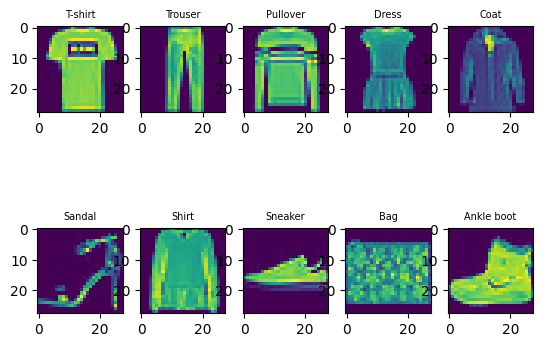

In [19]:
num_classes = len(np.unique(Y))
unique_classes = [X[np.where(Y == i)[0][0]] for i in range(num_classes)]
class_names = ["T-shirt", "Trouser", "Pullover", "Dress",
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
images = []
classes = []
for i in range(1, num_classes+1):
    plt.subplot(2, 5, i)
    plt.imshow(unique_classes[i-1])
    plt.title(class_names[i-1], fontdict={'fontsize': 7})
plt.show()


### Data Cleaning

In [20]:
num_features = np.shape(X)[1]*np.shape(X)[2]
X = X/255.0
X_test = X_test/255.0
X = X.reshape(np.shape(X)[0], 784)
X_test = X_test.reshape(np.shape(X_test)[0], 784)
X_train, Xv, Y_train, Yv = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.1, random_state=4, shuffle=True)
print("Size of Training DataSet =", len(X_train))
print("Size of Validation DataSet =", len(Xv))
print("Size of Test DataSet =", len(X_test))
print("Number of classes =", num_classes)
print("Number of features =", num_features)
X_train = X_train.T
Xv = Xv.T
X_test = X_test.T


Size of Training DataSet = 54000
Size of Validation DataSet = 6000
Size of Test DataSet = 10000
Number of classes = 10
Number of features = 784


### Activation Functions

In [21]:
def sigmoid(x):
    return 1. /(1. + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-(np.tanh(x)**2)

def der_relu(x):
    return (x>0)*1

def softmax(x):
    return (np.exp(x)/np.sum(np.exp(x),axis = 0))

def der_softmax(x):
    return softmax(x) * (1-softmax(x))

### Forward Propagation and Back Propagation

In [22]:
class Parameters:
    def __init__(self):
        pass
    
    def ForwardPropagation(self,X):
        W = self.W
        b = self.b
        A = [None]*len(W)
        H = [None]*len(b)
        for i in range(len(W)):
            if i == 0:
                A[i] = b[i] + W[i]@X
            else:
                A[i] = b[i] + W[i]@H[i-1]
            if i == len(W) - 1:
                H[i] = self.output_activation(A[i])
            else:
                H[i] = self.activation(A[i])
        self.A = A
        self.H = H
    
    def BackPropagation(self,X,Y):
        W = self.W
        b = self.b
        A = self.A
        H = self.H
        grad_a = [None]*len(A)
        grad_h = [None]*len(H)
        grad_w = [None]*len(W)
        grad_b = [None]*len(b)
        N = len(W)
        
        Y_hat = H[len(H)-1]
        if self.loss == "cross_entropy":
            grad_a[N-1] = Y_hat - Y
        elif self.loss == "mse":
            # diff = (Y_hat-Y)*Y_hat 
            # sum_diff = np.sum(Y_hat, axis=0)*Y_hat 
            grad_a[N-1] = (Y_hat-Y)*Y_hat - (np.sum(Y_hat, axis=0)*Y_hat)
            
        for i in range(N-1,-1,-1):
            if i == 0:
                grad_w[i] = grad_a[i]@X.T
            else:
                grad_w[i] = grad_a[i]@H[i-1].T
            grad_b[i] = np.sum(grad_a[i],axis=1,keepdims=True)
            if i>0 :
                grad_h[i-1] = W[i].T@grad_a[i]
                grad_a[i-1] = grad_h[i-1]*self.der_activation(A[i-1])
        for i in range(N):
            W[i] += self.weight_decay*W[i]   
        self.grad_w = grad_w
        self.grad_b = grad_b
        self.W = W
    

### Stochastic Gradient Descent

In [23]:
class sgd:
    def __init__(self):
        pass
    
    def update_sgd_params(self,eta):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        N = len(W)
        for i in range(N):
            W[i] = W[i] - eta*grad_w[i]
            b[i] = b[i] - eta*grad_b[i]
        
    

### Momentum Based Gradient Descent

In [24]:
class momentum():
    
    def __init__(self):
        pass
    
    def updade_momentum_params(self,eta,beta):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        N = len(grad_w)
        for i in range(N):
            u_W[i] = beta*u_W[i] + grad_w[i]
            u_b[i] = beta*u_b[i] + grad_b[i]
            W[i] = W[i] - eta*u_W[i]
            b[i] = b[i] - eta*u_b[i]


### Nesterov Accelerated Gradient Descent

In [25]:
class nesterov():
    
    def __init__(self):
        pass
    
    def update_nesterov_params(self,eta,beta,X,Y):
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        g_W = self.lookahead_params.W
        g_b = self.lookahead_params.b
        N = len(W)
        
        self.params.ForwardPropagation(X)
        self.params.BackPropagation(X,Y)
        
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        
        for i in range(N):
            g_W[i] = grad_w[i]
            g_b[i] = grad_b[i]
        
        
        for i in range(N):
            u_W[i] = beta*u_W[i] + g_W[i]
            u_b[i] = beta*u_b[i] + g_b[i]
            W[i] = W[i] - eta*(beta*u_W[i] + g_W[i])
            b[i] = b[i] - eta*(beta*u_b[i] + g_b[i])
    


### RMSProp

In [26]:
class rmsprop():
    
    def __init__(self):
        pass
    
    def update_rmsprop_params(self,eta,beta,epsilon):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        N = len(W)
        for i in range(N):
            u_W[i] = beta*u_W[i] + (1-beta)*np.multiply(grad_w[i],grad_w[i])
            u_b[i] = beta*u_b[i] + (1-beta)*np.multiply(grad_b[i],grad_b[i])
            W[i] = W[i] - (eta*grad_w[i]/(np.sqrt(u_W[i]+epsilon)))
            b[i] = b[i] - (eta*grad_b[i]/(np.sqrt(u_b[i]+epsilon)))


### Adam

In [27]:
class adam():
    
    def __init__(self):
        pass
    
    def update_adam_params(self,eta,beta1,beta2,epsilon):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        m_W = self.m_params.W
        m_b = self.m_params.b
        N = len(W)
        for i in range(N):
            m_W[i] = beta1*m_W[i] + (1-beta1)*grad_w[i]
            u_W[i] = beta2*u_W[i] + (1-beta2)*np.square(grad_w[i])
            m_hat_W = m_W[i]/(1.0-np.power(beta1,i+1))
            u_hat_W = u_W[i]/(1.0-np.power(beta2,i+1))
            W[i] = W[i] - (eta/(np.sqrt(u_hat_W)+epsilon))*m_hat_W
            
            m_b[i] = beta1*m_b[i] + (1-beta1)*grad_b[i]
            u_b[i] = beta2*u_b[i] + (1-beta2)*np.square(grad_b[i])
            m_hat_b = m_b[i]/(1.0-np.power(beta1,i+1))
            u_hat_b = u_b[i]/(1.0-np.power(beta2,i+1))
            b[i] = b[i] - (eta/(np.sqrt(u_hat_b)+epsilon))*m_hat_b


### NAdam

In [28]:
class nadam():
    
    def __init__(self):
        pass
    
    def update_nadam_params(self,eta,beta,beta1,beta2,epsilon,X,Y):
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        m_W = self.m_params.W
        m_b = self.m_params.b
        g_W = self.lookahead_params.W
        g_b = self.lookahead_params.b
        N = len(W)
        
        self.params.ForwardPropagation(X)
        self.params.BackPropagation(X,Y)
        
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        
        for i in range(N):
            g_W[i] = grad_w[i]
            g_b[i] = grad_b[i]
            
        for i in range(N):
            m_W[i] = beta1*m_W[i] + g_W[i]
            m_b[i] = beta1*m_b[i] + g_b[i]
            
            u_W[i] = beta2*u_W[i] + (1-beta2)*np.square(grad_w[i])
            u_b[i] = beta2*u_b[i] + (1-beta2)*np.square(grad_b[i])
            
            m_hat_W = (beta1*m_W[i] + g_W[i])/(1-np.power(beta1,i+1))
            m_hat_b = (beta1*m_b[i] + g_b[i])/(1-np.power(beta1,i+1))
            u_hat_W = u_W[i]/(1-np.power(beta2,i+1))
            u_hat_b = u_b[i]/(1-np.power(beta2,i+1))
            
            W[i] = W[i] - (eta*m_hat_W/(np.sqrt(u_hat_W)+epsilon))
            b[i] = b[i] - (eta*m_hat_b/(np.sqrt(u_hat_b)+epsilon))
        

### Insert Your optimizer here

In [29]:
class optimizer_name():
    '''
        Refer to the above optimizers for better understanding on how to use this class
    '''
    def __init__(self):
        pass
    
    def update_optimizer_name_params(self,):
        '''
            Add your code to update parameters
        '''
        pass

### Feedforward Neural Network

In [30]:
class NeuralNet:
    '''
        weight_initializers : dictionary with random , xavier
        weight_initializer : function
        activation_funtions : dictionary with sigmoid, tanh, relu
        der_activation_functions : dictionary with derivatives of the above
        optimizer_funtions : dictionary with sgd, momentum, nesterov, rmsprop, adam, nadam}
        activation : string
        opitmizer : string
        learning_rate : int
        batch_size : int
        num_epochs : int
        num_features : dimension of X
        num_hidden_layers : int, number of hidden layers
        output_layer_dim : int
        hidden_layer_dims : np.array with num_neurons in all hidden layer 
        weight_Decay : L2 regularisation
        X_train : Training Data (n,d)
        Y_train : Training Data (n,)
        Xv : Validation Data (n,d)
        Yv : Validation Data (n,)
        hidden_layers : np.array of objects to class hidden_layer dimensions = num_hidden_layers
        output_layer : object to hidden_layer class
        params : It is a object of class parameter which has the weights and biases of the neural network
        optimizer_object : object to the optimizer class, initialised in the initialize_neuralnet funciton
        beta : momentum,neterov,rmsprop,nadam
        beta1 : adam,nadam
        beta2 : adam,nadam
        epsilon : rmsprop,adam,nadam
    '''
    def __init__(self,
                 num_features,
                 weight_initializer,
                 num_hidden_layers,
                 hidden_layer_dims,
                 optimizer,
                 learning_rate,
                 activation,
                 X_train,
                 Y_train,
                 Xv,
                 Yv,
                 weight_decay,
                 output_layer_dim,
                 batch_size,
                 num_epochs,
                 loss = 'cross_entropy',
                 output_activation = softmax,
                 der_output_activation = der_softmax,
                 beta=0.9,
                 epsilon=1e-8,
                 beta1=0.9,
                 beta2=0.999):
        self.weight_initializers = {"random": self.random_initialization, "xavier": self.xavier_intialization}
        self.weight_initializer = self.weight_initializers[weight_initializer]
        self.activation_functions = {"sigmoid": sigmoid, "tanh": tanh, "ReLU": relu}
        self.der_activation_functions = {"sigmoid": der_sigmoid, "tanh": der_tanh, "ReLU": der_relu}
        self.loss_functions = {'cross_entropy':self.Cross_Entropy_Loss,'mse' : self.Square_Error_Loss}
        self.loss_str = loss
        self.loss = self.loss_functions[loss]
        '''
            Add your optimizer function and class in the below dictionaries
        '''
        self.optimizer_functions = {"sgd": self.sgd, "momentum": self.momentum,"nesterov": self.nesterov, "rmsprop": self.rmsprop, "adam": self.adam, "nadam": self.nadam}
        self.optimizer_classes = {"sgd": sgd, "momentum": momentum,"nesterov": nesterov, "rmsprop": rmsprop, "adam": adam, "nadam": nadam}
        self.activation = self.activation_functions[activation]
        self.optimizer = self.optimizer_functions[optimizer]
        self.optimizer_class = self.optimizer_classes[optimizer]
        self.der_activation = self.der_activation_functions[activation]
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_hidden_layers = num_hidden_layers
        self.output_layer_dim = output_layer_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.num_features = num_features
        self.output_activation = output_activation
        self.der_output_activation = der_output_activation
        self.weight_decay = weight_decay
        self.X_train = X_train
        self.Y_train = Y_train
        self.old_Y_train = Y_train
        self.Xv = Xv
        self.Yv = Yv
        self.old_Yv = Yv
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.num_classes = self.output_layer_dim
        # return self
        
    def Square_Error_Loss(self,Y_pred,Y_actual):
        return np.mean((Y_pred-Y_actual)**2)
    
    def Cross_Entropy_Loss(self,Y_pred,Y_actual):
        return (-1.0*np.sum(np.multiply(Y_actual+1,np.log(Y_pred+1))))/float(Y_pred.shape[0])
    
    def random_initialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)

    def xavier_intialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)* np.sqrt(2 / (in_layer + out_layer))
    
    '''
        The below optimizer functions are used to call the update_params methods in of their respective params
    '''
    
    def sgd(self,X,Y):
        sgd_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        sgd_obj.update_sgd_params(self.learning_rate)
        # for i in range(len(self.params.W)):
        #     print(self.params.W[i])
    
    def momentum(self,X,Y):
        momentum_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        momentum_obj.updade_momentum_params(self.learning_rate,self.beta)

    def nesterov(self,X,Y):
        nesterov_obj = self.optimizer_object
        nesterov_obj.update_nesterov_params(self.learning_rate,self.beta,X,Y)
    
    def rmsprop(self,X,Y):
        rmsprop_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        rmsprop_obj.update_rmsprop_params(self.learning_rate,self.beta,self.epsilon)
    
    def adam(self,X,Y):
        adam_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        adam_obj.update_adam_params(self.learning_rate,self.beta1,self.beta2,self.epsilon)
    
    def nadam(self,X,Y):
        nadam_obj = self.optimizer_object
        nadam_obj.update_nadam_params(self.learning_rate,self.beta,self.beta1,self.beta2,self.epsilon,X,Y)
    
    def optimzizer_name(self,X,Y):
        '''
            May implement forward and backpropagation here 
            Add code to create an object to your optimizer class
            Then use this object to call your optimizer_update method 
        '''
        pass
    
    def sanitize_Y(self):
        
        temp = np.zeros((self.num_classes,self.Y_train.shape[0]))
        for i in range(self.Y_train.shape[0]) :
            temp[int(self.Y_train[i])][i] = 1
        self.Y_train = temp
        
        temp = np.zeros((self.num_classes,self.Yv.shape[0]))
        for i in range(self.Yv.shape[0]) :
            temp[int(self.Yv[i])][i] = 1
        self.Yv = temp
        
    def initialize_NeuralNet(self):
        self.sanitize_Y()
        self.optimizer_object = self.optimizer_class()
        self.params = self.initialize_parameters()
        self.optimizer_object.params = self.params
        self.optimizer_object.u_params = self.zero_initializer()
        self.optimizer_object.m_params = self.zero_initializer()
        self.optimizer_object.lookahead_params = self.zero_initializer()
        '''
            can add required optimizer params and 
            initialize them here 
        '''
        # pass
    
    
    def add_hidden(self,num_neurons,pos):
        '''
        This function can be used to insert a layer at any position
        (0 indexing)
        '''
        self.hidden_layer_dims.insert(pos,num_neurons)
        self.num_hidden_layers += 1
        
    def zero_initializer(self):
        params = Parameters()
        W = []
        b = []
        in_layer, out_layer = self.num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = self.num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
            W.append(np.zeros(shape = (self.hidden_layer_dims[i],in_layer)))
            b.append(np.zeros(shape = (self.hidden_layer_dims[i],1)))
        W.append(np.zeros(shape = (self.num_classes,self.hidden_layer_dims[self.num_hidden_layers-1])))
        b.append(np.zeros(shape=(self.num_classes,1)))
        params.W = W
        params.b = b
        params.activation = self.activation
        params.output_activation = self.output_activation
        params.der_activation = self.der_activation
        params.weight_decay = self.weight_decay
        params.loss = self.loss_str
        return params
    
    def initialize_parameters(self):
        params = Parameters()
        W = []
        b = []
        in_layer, out_layer = self.num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = self.num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
            W.append(self.weight_initializer(self.hidden_layer_dims[i],in_layer))
            b.append(np.zeros(shape=(self.hidden_layer_dims[i],1)))
        W.append(self.weight_initializer(self.num_classes,self.hidden_layer_dims[self.num_hidden_layers-1]))
        b.append(np.zeros(shape=(self.num_classes,1)))
        params.W = W
        params.b = b
        params.activation = self.activation
        params.output_activation = self.output_activation
        params.der_activation = self.der_activation
        params.weight_decay = self.weight_decay
        params.loss = self.loss_str
        return params
    
    def fit_NeuralNet(self):
        self.initialize_NeuralNet()
        for curr_epoch in range(self.num_epochs):
            print("Epoch Number : ",curr_epoch+1)  
            for i in range(0,self.X_train.shape[1],self.batch_size):
                curr_batch = min(self.X_train.shape[1]-i,self.batch_size)
                self.optimizer(self.X_train[:,i:i+curr_batch],self.Y_train[:,i:i+curr_batch])
            train_acc,validation_acc,training_loss,validation_loss = self.accuracy_NeuralNet(self.old_Y_train,self.old_Yv)
            wandb.log({ "training_accuracy" : train_acc,
                        "validation_accuracy" : validation_acc,
                        "training_loss" : training_loss,
                        "validation_loss" : validation_loss,
                        "epoch" : curr_epoch+1})
            # '''
            #     print loss here
            #      and change it in NeuralNet.py
            # '''
            # Y_pred = self.predict_NeuralNet(self.X_train)
            # print("Cross Entropy Loss in the",curr_epoch+1,"epoch :",self.Cross_Entropy_Loss(Y_pred, Y_train))
            print(train_acc,validation_acc,training_loss,validation_loss)
        # pass
    
    def predict_NeuralNet(self,X):
        self.params.ForwardPropagation(X)
        Y_pred = np.argmax(self.params.H[len(self.params.H)-1],axis=0)
        return Y_pred
    
    def accuracy_NeuralNet(self,Y_train,Yv):
        Y_train_pred = self.predict_NeuralNet(self.X_train)
        Yv_pred = self.predict_NeuralNet(self.Xv)
        training_Loss = self.loss(Y_train_pred,self.old_Y_train)
        validation_Loss = self.loss(Yv_pred,self.old_Yv)
        return self.accuracy_score(Y_train_pred,Y_train),self.accuracy_score(Yv_pred,Yv),training_Loss,validation_Loss
    
    def accuracy_score(self, Y_pred, Y_train):
        return np.sum(Y_pred == Y_train)/Y_train.shape[0]
        # print("Training Accuracy =",accuracy_score(Y_train_pred,Y_train))
        # print("Test Accuracy =",accuracy_score(Yv_pred,Yv))


In [31]:
# NUM_FEATURES = X_train.shape[0]
# WEIGHT_INITIALIZER = "xavier"
# NUM_HIDDEN_LAYERS = 5
# # HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
# HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
# OPTIMIZER = "nesterov"
# LEARNING_RATE = 0.001
# ACTIVATION = "ReLU"
# OUTPUT_LAYER_DIM = num_classes
# BATCH_SIZE = 128
# EPOCHS = 5
# WEIGHT_DECAY = 0.0005

# N = NeuralNet(num_features = NUM_FEATURES,
#                 weight_initializer = WEIGHT_INITIALIZER,
#                 num_hidden_layers = NUM_HIDDEN_LAYERS,
#                 hidden_layer_dims = HIDDEN_LAYER_DIMS,
#                 optimizer = OPTIMIZER,
#                 learning_rate = LEARNING_RATE,
#                 activation = ACTIVATION,
#                 X_train = X_train,
#                 Y_train = Y_train,
#                 Xv = Xv,
#                 Yv = Yv,
#                 weight_decay=WEIGHT_DECAY,
#                 output_layer_dim = OUTPUT_LAYER_DIM,
#                 batch_size = BATCH_SIZE,
#                 num_epochs = EPOCHS)
# N.fit_NeuralNet()
# N.accuracy_NeuralNet(Y_train,Yv)


### Training the Model using Cross Entropy Loss for the best Hyperparameters

In [32]:
wandb.init(project="CS6910_Assignment_1")
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "xavier"
NUM_HIDDEN_LAYERS = 3
# HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "nadam"
LEARNING_RATE = 0.001
ACTIVATION = "ReLU"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 256
EPOCHS = 10
WEIGHT_DECAY = 0.0001
LOSS = 'cross_entropy'

run_name = "Entropy_Loss_Best_Hyperparameter"

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS,
                loss=LOSS)
N.fit_NeuralNet()
N.accuracy_NeuralNet(Y_train,Yv)
wandb.run.name = run_name
wandb.run.save()
wandb.finish()

Epoch Number :  1
0.8583518518518518 0.8593333333333333 -9.881718311481015 -9.832623743330368
Epoch Number :  2
0.8739074074074074 0.8695 -9.998994029351648 -9.936105850082113
Epoch Number :  3
0.8816296296296297 0.8725 -10.011614667295765 -9.937787032715516
Epoch Number :  4
0.8857037037037037 0.8743333333333333 -10.007209023215001 -9.922795227044567
Epoch Number :  5
0.8908333333333334 0.875 -10.068416394138213 -9.966420635406514
Epoch Number :  6
0.8942407407407408 0.8778333333333334 -10.068418410798278 -9.960335402100599
Epoch Number :  7
0.8952407407407408 0.8778333333333334 -10.071190188169785 -9.969536524218153
Epoch Number :  8
0.8972592592592593 0.8803333333333333 -10.054218820762719 -9.953857783391584
Epoch Number :  9
0.8993888888888889 0.8791666666666667 -10.084177236558778 -9.96021132526913
Epoch Number :  10
0.9022407407407408 0.8816666666666667 -10.072897659894478 -9.953066114615105


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▆▇▇▇██
training_loss,█▄▄▄▂▂▁▂▁▁
validation_accuracy,▁▄▅▆▆▇▇█▇█
validation_loss,█▃▃▃▁▁▁▂▁▂
epoch,10
training_accuracy,0.90224
training_loss,-10.0729
validation_accuracy,0.88167
validation_loss,-9.95307


In [35]:
wandb.finish()

In [36]:
wandb.init(project="CS6910_Assignment_1")
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "xavier"
NUM_HIDDEN_LAYERS = 2
# HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "rmsprop"
LEARNING_RATE = 0.001
ACTIVATION = "ReLU"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 512
EPOCHS = 10
WEIGHT_DECAY = 0.001
LOSS = 'mse'

run_name = "MSE_Loss_Best_Hyperparameter"

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS,
                loss = LOSS)
N.fit_NeuralNet()
N.accuracy_NeuralNet(Y_train,Yv)
wandb.run.name = run_name
wandb.run.save()
wandb.finish()

Epoch Number :  1


/tmp/ipykernel_18989/2446329309.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_18989/2446329309.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


0.0997962962962963 0.10183333333333333 28.522574074074075 28.296833333333332
Epoch Number :  2


KeyboardInterrupt: 

In [151]:
def train():
    config_defaults = {
        "num_epochs" : 10,
        "batch_size" : 256,
        "learning_rate" : 0.001,
        "activation" : "ReLU",
        "optimizer" : "nesterov",
        "weight_intializer" : "xavier",
        "weight_decay" : 0.0001,
        "hidden_layer_size" : 64,
        "num_hidden_layers" : 5,
    }
    
    wandb.init(config=config_defaults)
    # wandb.init()
    config = wandb.config
    HIDDEN_LAYER_SIZE = config.hidden_layer_size
    NUM_FEATURES = X_train.shape[0]
    WEIGHT_INITIALIZER = config.weight_initializer
    NUM_HIDDEN_LAYERS = config.num_hidden_layers
    HIDDEN_LAYER_DIMS = (config.hidden_layer_size+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
    OPTIMIZER = config.optimizer
    LEARNING_RATE = config.learning_rate
    ACTIVATION = config.activation
    OUTPUT_LAYER_DIM = num_classes
    BATCH_SIZE = config.batch_size
    EPOCHS = config.num_epochs
    WEIGHT_DECAY = config.weight_decay
    
    run_name = "op_{}_ac_{}_wi_{}_lr_{}_bs_{}_l2_{}_nh_{}_sh_{}_ep_{}".format(OPTIMIZER,ACTIVATION,WEIGHT_INITIALIZER,LEARNING_RATE,BATCH_SIZE,WEIGHT_DECAY,NUM_HIDDEN_LAYERS,HIDDEN_LAYER_SIZE,EPOCHS)
    
    FFN = NeuralNet(num_features = NUM_FEATURES,
                    weight_initializer = WEIGHT_INITIALIZER,
                    num_hidden_layers = NUM_HIDDEN_LAYERS,
                    hidden_layer_dims = HIDDEN_LAYER_DIMS,
                    optimizer = OPTIMIZER,
                    learning_rate = LEARNING_RATE,
                    activation = ACTIVATION,
                    X_train = X_train,
                    Y_train = Y_train,
                    Xv = Xv,
                    Yv = Yv,
                    weight_decay=WEIGHT_DECAY,
                    output_layer_dim = OUTPUT_LAYER_DIM,
                    batch_size = BATCH_SIZE,
                    num_epochs = EPOCHS)
    FFN.fit_NeuralNet()
    Y_pred_test = FFN.predict_NeuralNet(X_test)
    print("Test Accuracy :",FFN.accuracy_score(Y_pred_test,Y_test))
    wandb.run.name = run_name
    wandb.run.save()
    
    
    
    

In [152]:
sweep_config = {
    # "name" : "assignment_sweeps",
    "method" : "bayes",
    "metric" :{
        "name" : "validation_accuracy",
        "goal" : "maximize"
    },
    "parameters" : {
        "num_epochs" : {
            "values" : [5,8,10]
        },
        "num_hidden_layers" : {
            "values" : [2, 3, 4, 5]
        },
        "hidden_layer_size" : {
            "values" : [32, 64, 128]
        },
        "weight_decay" : {
            "values" : [0.0001,0.0005,0.001]
        },
        "learning_rate" : {
            "values" : [0.001,0.0001]
        },
        "optimizer" : {
           "values" : ["rmsprop", "nadam", "adam", "sgd", "momentum", "nesterov"] 
        },
        "batch_size" : {
            "values" : [128,256,512]
        },
        "weight_initializer" : {
            "values" : ["random","xavier"]
        },
        "activation" : {
            "values" : ["tanh", "sigmoid", "ReLU"]
        },
    }
}


In [153]:
sweep_config1 = {
    # "name" : "assignment_sweeps",
    "method" : "grid",
    "metric" :{
        "name" : "validation_accuracy",
        "goal" : "maximize"
    },
    "parameters" : {
        "num_epochs" : {
            "values" : [5,10]
        },
        "num_hidden_layers" : {
            "values" : [3]
        },
        "hidden_layer_size" : {
            "values" : [128]
        },
        "weight_decay" : {
            "values" : [0.0001]
        },
        "learning_rate" : {
            "values" : [0.001,0.0001]
        },
        "optimizer" : {
           "values" : ["nadam", "adam", "nesterov"] 
        },
        "batch_size" : {
            "values" : [128,256,512]
        },
        "weight_initializer" : {
            "values" : ["xavier"]
        },
        "activation" : {
            "values" : ["ReLU"]
        },
    }
}


In [154]:
sweep_id1 = wandb.sweep(sweep_config1,project="CS6910_Assignment_1")
wandb.agent(sweep_id=sweep_id1,function=train,count = 40)

Create sweep with ID: uw4sj0sv
Sweep URL: https://wandb.ai/cs20b009/CS6910_Assignment_1/sweeps/uw4sj0sv


wandb: Agent Starting Run: xe8yztah with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8636296296296296 0.8568333333333333 -9.970058264056993 -9.912764323481618
Epoch Number :  2
0.8729629629629629 0.8673333333333333 -10.01696322478607 -9.945630477551136
Epoch Number :  3
0.8834444444444445 0.8725 -10.062407849749654 -9.973820500379329
Epoch Number :  4
0.8864074074074074 0.8723333333333333 -10.059188332246702 -9.95309603118973
Epoch Number :  5
0.8908888888888888 0.8735 -10.10562519082508 -10.010021542489543
Test Accuracy : 0.869


epoch,▁▃▅▆█
training_accuracy,▁▃▆▇█
training_loss,█▆▃▃▁
validation_accuracy,▁▅███
validation_loss,█▆▄▅▁
epoch,5
training_accuracy,0.89089
training_loss,-10.10563
validation_accuracy,0.8735
validation_loss,-10.01002


wandb: Agent Starting Run: 46nnfk3z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8546296296296296 0.8528333333333333 -9.958256729795199 -9.895726037765108
Epoch Number :  2
0.8706851851851852 0.8625 -10.05360939004206 -9.962014221040942
Epoch Number :  3
0.8786851851851852 0.8676666666666667 -10.068643458901587 -9.984541696231597
Epoch Number :  4
0.8859444444444444 0.8735 -10.056892638886644 -9.966320595404843
Epoch Number :  5
0.8901666666666667 0.875 -10.070819604401906 -9.97423022119756
Test Accuracy : 0.8657


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▂▁▂▁
validation_accuracy,▁▄▆██
validation_loss,█▃▁▂▂
epoch,5
training_accuracy,0.89017
training_loss,-10.07082
validation_accuracy,0.875
validation_loss,-9.97423


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nx4dgau0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.843462962962963 0.8393333333333334 -10.057516442703895 -10.001183225180187
Epoch Number :  2
0.8628148148148148 0.8551666666666666 -10.04658832531695 -9.984463429182966
Epoch Number :  3
0.8680925925925926 0.857 -10.089990486433715 -10.014575182152136
Epoch Number :  4
0.8773888888888889 0.868 -10.097487458106182 -10.012057821365831
Epoch Number :  5
0.8738703703703704 0.8608333333333333 -10.036389305322574 -9.9628433703646
Test Accuracy : 0.8508


epoch,▁▃▅▆█
training_accuracy,▁▅▆█▇
training_loss,▆▇▂▁█
validation_accuracy,▁▅▅█▆
validation_loss,▃▅▁▁█
epoch,5
training_accuracy,0.87387
training_loss,-10.03639
validation_accuracy,0.86083
validation_loss,-9.96284


wandb: Agent Starting Run: wp49jjeo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8600740740740741 0.8523333333333334 -9.904435400706266 -9.840037748891248
Epoch Number :  2
0.878462962962963 0.8656666666666667 -9.992227949752488 -9.911440897456067
Epoch Number :  3
0.8843888888888889 0.8701666666666666 -9.99866817778893 -9.935139049070646
Epoch Number :  4
0.8926666666666667 0.8736666666666667 -10.051789007338842 -9.970840061526639
Epoch Number :  5
0.8913333333333333 0.8726666666666667 -10.082150973771144 -9.982093488814382
Epoch Number :  6
0.8942222222222223 0.8741666666666666 -10.10955232844659 -10.00501679668474
Epoch Number :  7
0.8988888888888888 0.877 -10.127748582894856 -10.026007417628115
Epoch Number :  8
0.9015 0.8833333333333333 -10.111878900856892 -10.008010492611055
Epoch Number :  9
0.9014814814814814 0.8776666666666667 -10.115444717923776 -9.987470321020174
Epoch Number :  10
0.9018148148148148 0.8795 -10.105471165186021 -9.987006942295357
Test Accuracy : 0.8681


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇████
training_loss,█▅▅▃▂▂▁▁▁▂
validation_accuracy,▁▄▅▆▆▆▇█▇▇
validation_loss,█▅▄▃▃▂▁▂▂▂
epoch,10
training_accuracy,0.90181
training_loss,-10.10547
validation_accuracy,0.8795
validation_loss,-9.98701


wandb: Agent Starting Run: n2q4g5zo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8592407407407407 0.856 -9.968895775653028 -9.909868103347724
Epoch Number :  2
0.8736666666666667 0.865 -10.04985824076021 -9.963090623249983
Epoch Number :  3
0.8819259259259259 0.87 -10.064647121976915 -9.973285409618265
Epoch Number :  4
0.888425925925926 0.8768333333333334 -10.047449912732505 -9.957294684505
Epoch Number :  5
0.8935185185185185 0.8775 -10.036630295468326 -9.953857634593847
Epoch Number :  6
0.8970185185185185 0.8806666666666667 -10.052220874442154 -9.961643485748743
Epoch Number :  7
0.9004629629629629 0.8806666666666667 -10.04594676713162 -9.946950332805594
Epoch Number :  8
0.9032222222222223 0.8813333333333333 -10.048239475026794 -9.94221735410651
Epoch Number :  9
0.906537037037037 0.8831666666666667 -10.045102067667527 -9.946876211281863
Epoch Number :  10
0.9075740740740741 0.884 -10.056004933832165 -9.949036553183939
Test Accuracy : 0.8749


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▂▁▂▃▂▂▂▂▂
validation_accuracy,▁▃▅▆▆▇▇▇██
validation_loss,█▂▁▃▃▂▄▄▄▄
epoch,10
training_accuracy,0.90757
training_loss,-10.056
validation_accuracy,0.884
validation_loss,-9.94904


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yj6c9es1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8489629629629629 0.8448333333333333 -9.955780764711909 -9.898591293052274
Epoch Number :  2
0.8642777777777778 0.8505 -9.938230816906893 -9.87173417687702
Epoch Number :  3
0.8700925925925926 0.8566666666666667 -10.011857245569393 -9.927691560777964
Epoch Number :  4
0.8784814814814815 0.8596666666666667 -9.978753092489015 -9.886652294731556
Epoch Number :  5
0.884 0.8675 -10.01550578070746 -9.933826015049167
Epoch Number :  6
0.8877037037037037 0.8716666666666667 -10.075863418350535 -9.983669545683355
Epoch Number :  7
0.8911481481481481 0.8736666666666667 -10.05721730694162 -9.959885425772505
Epoch Number :  8
0.8960185185185185 0.8753333333333333 -10.052777841562044 -9.958474119292157
Epoch Number :  9
0.8983148148148148 0.8746666666666667 -10.015999336235502 -9.932236968002329
Epoch Number :  10
0.8937592592592593 0.8748333333333334 -10.006241124578773 -9.91304199903436
Test Accuracy : 0.8625


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇██▇
training_loss,▇█▄▆▄▁▂▂▄▅
validation_accuracy,▁▂▄▄▆▇████
validation_loss,▆█▅▇▄▁▂▃▄▅
epoch,10
training_accuracy,0.89376
training_loss,-10.00624
validation_accuracy,0.87483
validation_loss,-9.91304


wandb: Agent Starting Run: 8b76icxp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8630925925925926 0.858 -9.964989192368279 -9.875351124576364
Epoch Number :  2
0.8762777777777778 0.8661666666666666 -10.006131765332924 -9.906468675504152
Epoch Number :  3
0.8840370370370371 0.873 -10.030627194624934 -9.940816447839993
Epoch Number :  4
0.89 0.8776666666666667 -10.051439805689702 -9.967015984680813
Epoch Number :  5
0.8951111111111111 0.8778333333333334 -10.056605422035757 -9.963069692806746
Test Accuracy : 0.8728


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▅▃▁▁
validation_accuracy,▁▄▆██
validation_loss,█▆▃▁▁
epoch,5
training_accuracy,0.89511
training_loss,-10.05661
validation_accuracy,0.87783
validation_loss,-9.96307


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k3wlxaso with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8004444444444444 0.809 -9.825089999959483 -9.787549793553358
Epoch Number :  2
0.8282037037037037 0.83 -9.84409781880383 -9.788009952377463
Epoch Number :  3
0.8389444444444445 0.8403333333333334 -9.849468783847952 -9.789892403451454
Epoch Number :  4
0.8460555555555556 0.8453333333333334 -9.86785398792612 -9.801095255142153
Epoch Number :  5
0.8502037037037037 0.8501666666666666 -9.882225930160036 -9.819623293762108
Test Accuracy : 0.8385


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▆▅▃▁
validation_accuracy,▁▅▆▇█
validation_loss,██▇▅▁
epoch,5
training_accuracy,0.8502
training_loss,-9.88223
validation_accuracy,0.85017
validation_loss,-9.81962


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pol7yu19 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch Number :  1
0.8453888888888889 0.8426666666666667 -9.85311990130624 -9.787944884836582
Epoch Number :  2
0.8664259259259259 0.8576666666666667 -9.908861955695002 -9.83752284814463
Epoch Number :  3
0.8777592592592592 0.8641666666666666 -9.961880753386069 -9.87516198844053
Epoch Number :  4
0.8879444444444444 0.8701666666666666 -9.955597410501472 -9.874252450825907
Epoch Number :  5
0.8947037037037037 0.8748333333333334 -9.962337329838283 -9.865372826878957
Test Accuracy : 0.8688


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▄▁▁▁
validation_accuracy,▁▄▆▇█
validation_loss,█▄▁▁▂
epoch,5
training_accuracy,0.8947
training_loss,-9.96234
validation_accuracy,0.87483
validation_loss,-9.86537


wandb: Agent Starting Run: izw8c1dw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8647222222222222 0.8598333333333333 -9.989650832911684 -9.915433691117396
Epoch Number :  2
0.8770185185185185 0.869 -10.045980965848 -9.954962669018807
Epoch Number :  3
0.8848148148148148 0.874 -10.06204030907887 -9.963455671946699
Epoch Number :  4
0.8905925925925926 0.8748333333333334 -10.087666214894478 -9.968074761860501
Epoch Number :  5
0.8946851851851851 0.8773333333333333 -10.080815777248473 -9.965022491521594
Epoch Number :  6
0.8986666666666666 0.8796666666666667 -10.084014392659089 -9.968459384725747
Epoch Number :  7
0.9026851851851851 0.882 -10.090843026476653 -9.971422824957283
Epoch Number :  8
0.9057592592592593 0.8823333333333333 -10.098025135331847 -9.976624382895569
Epoch Number :  9
0.9083888888888889 0.8828333333333334 -10.093251994479639 -9.960717661905448
Epoch Number :  10
0.911962962962963 0.8845 -10.084022009249418 -9.947353486217025
Test Accuracy : 0.877


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▅▆▇▇▇█
training_loss,█▄▃▂▂▂▁▁▁▂
validation_accuracy,▁▄▅▅▆▇▇▇██
validation_loss,█▃▃▂▂▂▂▁▃▄
epoch,10
training_accuracy,0.91196
training_loss,-10.08402
validation_accuracy,0.8845
validation_loss,-9.94735


wandb: Agent Starting Run: 7o9tnfaw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7989444444444445 0.8008333333333333 -9.821268950108257 -9.766781370802429
Epoch Number :  2
0.8258703703703704 0.8335 -9.843661228044237 -9.806243716490986
Epoch Number :  3
0.8372962962962963 0.8388333333333333 -9.86694754917522 -9.810791011289623
Epoch Number :  4
0.8435185185185186 0.8433333333333334 -9.879980904976085 -9.835324895674976
Epoch Number :  5
0.8492592592592593 0.8486666666666667 -9.888357065703804 -9.846006162951117
Epoch Number :  6
0.8538148148148148 0.8525 -9.89183123310142 -9.855112050729382
Epoch Number :  7
0.8572037037037037 0.8546666666666667 -9.888622636939509 -9.844824892175124
Epoch Number :  8
0.8597592592592592 0.856 -9.886008005608806 -9.829780461714112
Epoch Number :  9
0.8610555555555556 0.859 -9.888554381667118 -9.834382206174919
Epoch Number :  10
0.8623703703703703 0.8613333333333333 -9.889595972419082 -9.842828682921429
Test Accuracy : 0.8444


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▆▃▂▁▁▁▂▁▁
validation_accuracy,▁▅▅▆▇▇▇▇██
validation_loss,█▅▅▃▂▁▂▃▃▂
epoch,10
training_accuracy,0.86237
training_loss,-9.8896
validation_accuracy,0.86133
validation_loss,-9.84283


wandb: Agent Starting Run: uxp5zfn9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8396296296296296 0.838 -9.861477159347205 -9.793339628593513
Epoch Number :  2
0.8638148148148148 0.856 -9.94534189563125 -9.888279839457537
Epoch Number :  3
0.8752592592592593 0.8615 -9.956531239710447 -9.882318234211535
Epoch Number :  4
0.8856296296296297 0.8696666666666667 -9.960210000220975 -9.885636931162427
Epoch Number :  5
0.8922962962962963 0.8731666666666666 -9.98545627156298 -9.915636610099236
Epoch Number :  6
0.897537037037037 0.8793333333333333 -9.9929867769857 -9.92090037280966
Epoch Number :  7
0.9016666666666666 0.8783333333333333 -10.009794766775077 -9.91146131897018
Epoch Number :  8
0.9063518518518519 0.878 -10.036265441856072 -9.946057194055982
Epoch Number :  9
0.9102222222222223 0.88 -10.031650348072276 -9.933621892931502
Epoch Number :  10
0.9118148148148149 0.8813333333333333 -10.052437767352348 -9.940783499468505
Test Accuracy : 0.8774


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▇▇▇██
training_loss,█▅▅▄▃▃▃▂▂▁
validation_accuracy,▁▄▅▆▇██▇██
validation_loss,█▄▄▄▂▂▃▁▂▁
epoch,10
training_accuracy,0.91181
training_loss,-10.05244
validation_accuracy,0.88133
validation_loss,-9.94078


wandb: Agent Starting Run: 616s4my7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8554259259259259 0.8525 -9.938235122655364 -9.891669725903267
Epoch Number :  2
0.8733703703703704 0.8636666666666667 -9.963263674811458 -9.903615564010128
Epoch Number :  3
0.8795 0.8656666666666667 -10.007993125809575 -9.93108121075103
Epoch Number :  4
0.8862777777777778 0.8701666666666666 -10.000335065199144 -9.91298381660442
Epoch Number :  5
0.8912037037037037 0.8738333333333334 -10.034520834422652 -9.943661410709925
Test Accuracy : 0.869


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▆▃▃▁
validation_accuracy,▁▅▅▇█
validation_loss,█▆▃▅▁
epoch,5
training_accuracy,0.8912
training_loss,-10.03452
validation_accuracy,0.87383
validation_loss,-9.94366


wandb: Agent Starting Run: yon0aden with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8412962962962963 0.8428333333333333 -9.955002905255956 -9.898317649037367
Epoch Number :  2
0.8663518518518518 0.8601666666666666 -9.981582692898922 -9.908668197961209
Epoch Number :  3
0.8740370370370371 0.8655 -9.93407425463688 -9.84622664735663
Epoch Number :  4
0.8785740740740741 0.8718333333333333 -9.920347768636525 -9.82721310509078
Epoch Number :  5
0.8828888888888888 0.8721666666666666 -9.927882352837955 -9.821472202732933
Test Accuracy : 0.8624


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,▄▁▆█▇
validation_accuracy,▁▅▆██
validation_loss,▂▁▆██
epoch,5
training_accuracy,0.88289
training_loss,-9.92788
validation_accuracy,0.87217
validation_loss,-9.82147


wandb: Agent Starting Run: 4h7um4mp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.36183333333333334 0.3546666666666667 -8.109767750453855 -8.037973061731826
Epoch Number :  2
0.09996296296296296 0.10016666666666667 -10.692677426218372 -10.655871755307446
Epoch Number :  3
0.09996296296296296 0.1005 -7.628136066297795 -7.604748766983345
Epoch Number :  4
0.10033333333333333 0.09716666666666667 -12.666876572777763 -12.626852028938515
Epoch Number :  5
0.09994444444444445 0.1005 -7.6269551488790635 -7.603593521682412
Test Accuracy : 0.1


epoch,▁▃▅▆█
training_accuracy,█▁▁▁▁
training_loss,▇▄█▁█
validation_accuracy,█▁▁▁▁
validation_loss,▇▄█▁█
epoch,5
training_accuracy,0.09994
training_loss,-7.62696
validation_accuracy,0.1005
validation_loss,-7.60359


wandb: Agent Starting Run: 6ohgq51p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8637407407407407 0.86 -9.896991334576747 -9.83655039706243
Epoch Number :  2
0.8775925925925926 0.8698333333333333 -10.02442560311814 -9.942851608102654
Epoch Number :  3
0.885 0.8736666666666667 -10.04676346612888 -9.958865725474924
Epoch Number :  4
0.8921111111111111 0.8738333333333334 -10.076400556811503 -9.963807267321478
Epoch Number :  5
0.896537037037037 0.8773333333333333 -10.054493260020765 -9.944257948441935
Epoch Number :  6
0.8993888888888889 0.8766666666666667 -10.073643000251403 -9.958670921586313
Epoch Number :  7
0.9021296296296296 0.8786666666666667 -10.060061663983333 -9.957059597793357
Epoch Number :  8
0.9031666666666667 0.8765 -10.076092666669162 -9.955632959392778
Epoch Number :  9
0.9032222222222223 0.8741666666666666 -10.076828478299198 -9.961211865124968
Epoch Number :  10
0.9025 0.8738333333333334 -10.081973504829804 -9.96255233503941
Test Accuracy : 0.8691


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆▇▇████
training_loss,█▃▂▁▂▁▂▁▁▁
validation_accuracy,▁▅▆▆█▇█▇▆▆
validation_loss,█▂▁▁▂▁▁▁▁▁
epoch,10
training_accuracy,0.9025
training_loss,-10.08197
validation_accuracy,0.87383
validation_loss,-9.96255


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydwlz2z7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.843574074074074 0.8425 -9.956978518729999 -9.888134075184974
Epoch Number :  2
0.8643518518518518 0.8621666666666666 -9.964267471145735 -9.891825688520129
Epoch Number :  3
0.8734814814814815 0.8665 -9.957344257532103 -9.882727270687612
Epoch Number :  4
0.8795740740740741 0.8681666666666666 -9.96662087720059 -9.878664171851101
Epoch Number :  5
0.8841296296296296 0.8698333333333333 -9.974890359251658 -9.877446465218235
Epoch Number :  6
0.8877222222222222 0.8738333333333334 -9.971165605053777 -9.861799006883194
Epoch Number :  7
0.8917037037037037 0.8788333333333334 -9.98291416120767 -9.889630454779683
Epoch Number :  8
0.8952222222222223 0.8778333333333334 -9.982791100639382 -9.874100943611323
Epoch Number :  9
0.8986111111111111 0.8783333333333333 -9.987688912229492 -9.879208222145559
Epoch Number :  10
0.9003333333333333 0.8803333333333333 -9.977912131881865 -9.868334439973646
Test Accuracy : 0.8734


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▅▆▆▇▇██
training_loss,█▆█▆▄▅▂▂▁▃
validation_accuracy,▁▅▅▆▆▇████
validation_loss,▂▁▃▄▄█▂▅▄▆
epoch,10
training_accuracy,0.90033
training_loss,-9.97791
validation_accuracy,0.88033
validation_loss,-9.86833


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: igum6f3t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1


/tmp/ipykernel_5851/2446329309.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_5851/2446329309.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  2
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  3
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  4
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  5
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  6
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  7
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  8
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  9
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  10
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Test Accuracy : 0.1


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
validation_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
training_accuracy,0.0998
training_loss,-0.0
validation_accuracy,0.10183
validation_loss,-0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j60dw9yj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.857 0.8541666666666666 -10.002310732826887 -9.928054898288854
Epoch Number :  2
0.8711111111111111 0.8668333333333333 -10.041788787186109 -9.957606502205962
Epoch Number :  3
0.8796851851851852 0.8718333333333333 -10.046255685101082 -9.957964624864212
Epoch Number :  4
0.8849444444444444 0.8778333333333334 -10.047087527450048 -9.955990587166745
Epoch Number :  5
0.8897592592592592 0.8801666666666667 -10.042628121327063 -9.954789532455989
Test Accuracy : 0.8671


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▂▁▁▂
validation_accuracy,▁▄▆▇█
validation_loss,█▁▁▁▂
epoch,5
training_accuracy,0.88976
training_loss,-10.04263
validation_accuracy,0.88017
validation_loss,-9.95479


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c6mhf7z2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7759814814814815 0.7845 -9.892133449763724 -9.857860723655705
Epoch Number :  2
0.814037037037037 0.8161666666666667 -9.92375488773611 -9.890050066659487
Epoch Number :  3
0.8277962962962963 0.8326666666666667 -9.947244644816676 -9.924709211106059
Epoch Number :  4
0.8366296296296296 0.8395 -9.970761100369742 -9.939449278709581
Epoch Number :  5
0.842574074074074 0.843 -9.981931846665807 -9.94167243227482
Test Accuracy : 0.8277


wandb: Network error (ConnectionError), entering retry loop.
wandb: Ctrl + C detected. Stopping sweep.


wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/home/arunesh/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 2092, in _atexit_cleanup
    self._on_finish()
  File "/home/arunesh/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 2325, in _on_finish
    _ = exit_handle.wait(timeout=-1, on_progress=self._on_progress_exit)
  File "/home/arunesh/.local/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 283, in wait
    found, abandoned = self._slot._get_and_clear(timeout=wait_timeout)
  File "/home/arunesh/.local/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 130, in _get_and_clear
    if self._wait(timeout=timeout):
  File "/home/arunesh/.local/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 126, in _wait
    return self._event.wait(timeout=timeout)
  File "/usr/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 

In [155]:
wandb.agent(sweep_id=sweep_id1,function=train,count = 40)

wandb: Agent Starting Run: 5ahx2f1t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8465925925925926 0.8453333333333334 -9.888712246006676 -9.810811280040259
Epoch Number :  2
0.8685 0.8621666666666666 -9.930152557593251 -9.848334654975467
Epoch Number :  3
0.8802407407407408 0.872 -9.97954755651619 -9.90014332100983
Epoch Number :  4
0.8871666666666667 0.8708333333333333 -10.00609805546987 -9.923678207198645
Epoch Number :  5
0.8926296296296297 0.8745 -10.034687065585766 -9.94341013755316
Test Accuracy : 0.8696


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▆▄▂▁
validation_accuracy,▁▅▇▇█
validation_loss,█▆▃▂▁
epoch,5
training_accuracy,0.89263
training_loss,-10.03469
validation_accuracy,0.8745
validation_loss,-9.94341


wandb: Agent Starting Run: 61y6r717 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8572222222222222 0.8551666666666666 -9.97345971613889 -9.905602221589104
Epoch Number :  2
0.8715740740740741 0.8646666666666667 -10.011562022706832 -9.930051823391507
Epoch Number :  3
0.8779074074074074 0.8678333333333333 -10.03620188277169 -9.963810663833318
Epoch Number :  4
0.8845185185185185 0.8731666666666666 -10.038989937202903 -9.967535087742002
Epoch Number :  5
0.889962962962963 0.8776666666666667 -10.041742357081962 -9.968060679627088
Epoch Number :  6
0.8933888888888889 0.879 -10.048055073250646 -9.97086577066749
Epoch Number :  7
0.8962592592592593 0.8793333333333333 -10.05596443039952 -9.969074648472812
Epoch Number :  8
0.8985925925925926 0.8825 -10.055766647334158 -9.972554907877075
Epoch Number :  9
0.9012592592592592 0.8831666666666667 -10.060295441162522 -9.972505788458214
Epoch Number :  10
0.9044814814814814 0.8851666666666667 -10.059084576352689 -9.974717389835599
Test Accuracy : 0.8731


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▅▃▃▂▂▁▁▁▁
validation_accuracy,▁▃▄▅▆▇▇▇██
validation_loss,█▆▂▂▂▁▂▁▁▁
epoch,10
training_accuracy,0.90448
training_loss,-10.05908
validation_accuracy,0.88517
validation_loss,-9.97472


wandb: Agent Starting Run: l4pcijmv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7850370370370371 0.7893333333333333 -9.941346525398812 -9.90688923841035
Epoch Number :  2
0.8158333333333333 0.8205 -9.95547938734401 -9.905583697351817
Epoch Number :  3
0.8297037037037037 0.8326666666666667 -9.966102322381984 -9.918189448642428
Epoch Number :  4
0.8385925925925926 0.8383333333333334 -9.969277831670453 -9.930982785396909
Epoch Number :  5
0.8445370370370371 0.8431666666666666 -9.98165492905985 -9.926882085889927
Epoch Number :  6
0.8494444444444444 0.8451666666666666 -9.991642588698527 -9.919923991723834
Epoch Number :  7
0.8528333333333333 0.8468333333333333 -9.99945411024333 -9.92887909630492
Epoch Number :  8
0.8561666666666666 0.8491666666666666 -10.007177764620085 -9.93195577822591
Epoch Number :  9
0.8579074074074075 0.8528333333333333 -10.007226692694331 -9.923086393462128
Epoch Number :  10
0.8607222222222223 0.8553333333333333 -10.011456228966514 -9.932343666225021
Test Accuracy : 0.8447


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▇▆▅▄▃▂▁▁▁
validation_accuracy,▁▄▆▆▇▇▇▇██
validation_loss,██▅▁▂▄▂▁▃▁
epoch,10
training_accuracy,0.86072
training_loss,-10.01146
validation_accuracy,0.85533
validation_loss,-9.93234


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dbpf9vrb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.843574074074074 0.8433333333333334 -9.881377420330669 -9.805373015481303
Epoch Number :  2
0.8673333333333333 0.8596666666666667 -9.917363362148752 -9.840599911004725
Epoch Number :  3
0.8780555555555556 0.8658333333333333 -9.938411481277894 -9.864866896917775
Epoch Number :  4
0.883962962962963 0.8711666666666666 -9.971364403857503 -9.880833103327532
Epoch Number :  5
0.8888518518518519 0.8718333333333333 -10.014689306453601 -9.919757505899812
Epoch Number :  6
0.8930555555555556 0.8735 -10.013680423826008 -9.894324635985116
Epoch Number :  7
0.8991111111111111 0.8765 -10.026691879918868 -9.90527511817833
Epoch Number :  8
0.9013888888888889 0.8783333333333333 -10.041267534872295 -9.917864902337575
Epoch Number :  9
0.9054814814814814 0.8813333333333333 -10.064102152612731 -9.943433578853453
Epoch Number :  10
0.9091111111111111 0.8811666666666667 -10.034567657906042 -9.901267118828805
Test Accuracy : 0.8737


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▅▆▆▇▇██
training_loss,█▇▆▅▃▃▂▂▁▂
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▆▅▄▂▃▃▂▁▃
epoch,10
training_accuracy,0.90911
training_loss,-10.03457
validation_accuracy,0.88117
validation_loss,-9.90127


wandb: Agent Starting Run: ll5geq3r with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8492222222222222 0.8493333333333334 -9.97010468166545 -9.88461419596962
Epoch Number :  2
0.8676111111111111 0.863 -10.023330168225236 -9.94610097744422
Epoch Number :  3
0.8771111111111111 0.87 -10.037189155219393 -9.963404354474848
Epoch Number :  4
0.8817037037037037 0.8705 -10.053637333254539 -9.962020328940955
Epoch Number :  5
0.887425925925926 0.8748333333333334 -10.055512421277813 -9.965560408173687
Test Accuracy : 0.8638


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▄▃▁▁
validation_accuracy,▁▅▇▇█
validation_loss,█▃▁▁▁
epoch,5
training_accuracy,0.88743
training_loss,-10.05551
validation_accuracy,0.87483
validation_loss,-9.96556


wandb: Agent Starting Run: x3mohi0q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8353333333333334 0.837 -9.789115434682294 -9.764458735858906
Epoch Number :  2
0.8543333333333333 0.8511666666666666 -9.82700285031623 -9.787770858900316
Epoch Number :  3
0.8613148148148149 0.8563333333333333 -9.775182978971717 -9.712863179452077
Epoch Number :  4
0.8693518518518518 0.863 -9.7896987548134 -9.72777313043455
Epoch Number :  5
0.8753333333333333 0.866 -9.816956520088157 -9.74242434302679
Test Accuracy : 0.8582


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,▆▁█▆▂
validation_accuracy,▁▄▆▇█
validation_loss,▃▁█▇▅
epoch,5
training_accuracy,0.87533
training_loss,-9.81696
validation_accuracy,0.866
validation_loss,-9.74242


wandb: Agent Starting Run: upq4zik7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1


/tmp/ipykernel_5851/2446329309.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_5851/2446329309.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  2
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  3
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  4
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  5
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Test Accuracy : 0.1


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
validation_loss,▁▁▁▁▁
epoch,5
training_accuracy,0.0998
training_loss,-0.0
validation_accuracy,0.10183
validation_loss,-0.0


wandb: Agent Starting Run: nwupj4nn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8495370370370371 0.8441666666666666 -9.916786087928527 -9.859043410828525
Epoch Number :  2
0.8700740740740741 0.8601666666666666 -9.980394449045924 -9.903428150496582
Epoch Number :  3
0.8777407407407407 0.8691666666666666 -9.990894771697835 -9.906565300807406
Epoch Number :  4
0.8826481481481482 0.8678333333333333 -10.016202279785983 -9.935069467059796
Epoch Number :  5
0.8868148148148148 0.8693333333333333 -10.014667000103211 -9.924485643422546
Epoch Number :  6
0.8917777777777778 0.8723333333333333 -10.002160199587024 -9.91008683935711
Epoch Number :  7
0.8950185185185185 0.8748333333333334 -10.010378094657185 -9.912374193371953
Epoch Number :  8
0.8969259259259259 0.8758333333333334 -9.980729993204232 -9.874171893869992
Epoch Number :  9
0.897962962962963 0.874 -9.995548468878757 -9.877067825615702
Epoch Number :  10
0.9002777777777777 0.871 -9.987582507371638 -9.862298465149154
Test Accuracy : 0.8706


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▄▃▁▁▂▁▃▂▃
validation_accuracy,▁▅▇▆▇▇███▇
validation_loss,█▄▄▁▂▃▃▇▆█
epoch,10
training_accuracy,0.90028
training_loss,-9.98758
validation_accuracy,0.871
validation_loss,-9.8623


wandb: Agent Starting Run: zxzzpw1n with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8265185185185185 0.828 -9.729427302674146 -9.67894219695298
Epoch Number :  2
0.8511481481481481 0.8498333333333333 -9.78585893256829 -9.741118434836785
Epoch Number :  3
0.8607407407407407 0.8593333333333333 -9.738788291817723 -9.690822761109546
Epoch Number :  4
0.8685925925925926 0.8631666666666666 -9.75674276768151 -9.698790578468024
Epoch Number :  5
0.8761851851851852 0.87 -9.805859037432171 -9.7463940047323
Epoch Number :  6
0.8820370370370371 0.8741666666666666 -9.85367730653699 -9.788306706947274
Epoch Number :  7
0.8868333333333334 0.8756666666666667 -9.89256938392628 -9.824341280680285
Epoch Number :  8
0.8909074074074074 0.8796666666666667 -9.928793868805489 -9.850526027790492
Epoch Number :  9
0.8950925925925926 0.881 -9.966318061447405 -9.875459314423901
Epoch Number :  10
0.8975740740740741 0.8805 -9.981270445541927 -9.88739672202063
Test Accuracy : 0.8736


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▆█▇▆▅▃▂▁▁
validation_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▆█▇▆▄▃▂▁▁
epoch,10
training_accuracy,0.89757
training_loss,-9.98127
validation_accuracy,0.8805
validation_loss,-9.8874


wandb: Agent Starting Run: lazt2mx4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1


/home/arunesh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  2
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  3
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  4
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  5
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  6
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  7
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  8
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  9
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Epoch Number :  10
0.0997962962962963 0.10183333333333333 -0.0 -0.0
Test Accuracy : 0.1


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
validation_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
training_accuracy,0.0998
training_loss,-0.0
validation_accuracy,0.10183
validation_loss,-0.0


wandb: Agent Starting Run: 0dilfei3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8462037037037037 0.847 -9.98717710919988 -9.913847528818332
Epoch Number :  2
0.8620740740740741 0.8595 -9.980573019992395 -9.898242288367296
Epoch Number :  3
0.8724074074074074 0.8663333333333333 -9.974588364054672 -9.89495285831956
Epoch Number :  4
0.8796296296296297 0.8706666666666667 -9.977172054386326 -9.900929192713557
Epoch Number :  5
0.8851296296296296 0.8731666666666666 -9.98146118813513 -9.897565395292347
Test Accuracy : 0.8654


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,▁▅█▇▄
validation_accuracy,▁▄▆▇█
validation_loss,▁▇█▆▇
epoch,5
training_accuracy,0.88513
training_loss,-9.98146
validation_accuracy,0.87317
validation_loss,-9.89757


wandb: Agent Starting Run: hh0tzslm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7291851851851852 0.7293333333333333 -9.889312702239668 -9.84575958359264
Epoch Number :  2
0.7866111111111111 0.791 -9.937336513875621 -9.882420238924723
Epoch Number :  3
0.8093518518518519 0.8098333333333333 -9.961776818107591 -9.89469113142971
Epoch Number :  4
0.8229444444444445 0.825 -9.965668550648935 -9.91650327398718
Epoch Number :  5
0.8297037037037037 0.8328333333333333 -9.971607299664726 -9.914890089156058
Test Accuracy : 0.8191


epoch,▁▃▅▆█
training_accuracy,▁▅▇██
training_loss,█▄▂▂▁
validation_accuracy,▁▅▆▇█
validation_loss,█▄▃▁▁
epoch,5
training_accuracy,0.8297
training_loss,-9.97161
validation_accuracy,0.83283
validation_loss,-9.91489


wandb: Agent Starting Run: 27reydct with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8355185185185185 0.8356666666666667 -9.971214367645361 -9.913659627802097
Epoch Number :  2
0.8594074074074074 0.8528333333333333 -9.949489804061015 -9.859432446016825
Epoch Number :  3
0.8715185185185185 0.864 -9.99772570877815 -9.91867954111825
Epoch Number :  4
0.8790740740740741 0.8666666666666667 -10.010790661449706 -9.921412211514344
Epoch Number :  5
0.8848888888888888 0.8708333333333333 -10.028047983692073 -9.93800918746677
Test Accuracy : 0.8632


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,▆█▄▃▁
validation_accuracy,▁▄▇▇█
validation_loss,▃█▃▂▁
epoch,5
training_accuracy,0.88489
training_loss,-10.02805
validation_accuracy,0.87083
validation_loss,-9.93801


wandb: Agent Starting Run: 6pt3h2b9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8462592592592593 0.8443333333333334 -9.985628439830217 -9.929436284857186
Epoch Number :  2
0.8633148148148149 0.8583333333333333 -9.980715550266833 -9.914585864805726
Epoch Number :  3
0.8720740740740741 0.8651666666666666 -9.991287891983772 -9.922505825772241
Epoch Number :  4
0.8777592592592592 0.8681666666666666 -9.995609876847235 -9.912779280445728
Epoch Number :  5
0.883 0.8721666666666666 -9.996117917204415 -9.91821371137143
Epoch Number :  6
0.8868333333333334 0.8758333333333334 -9.995495921308265 -9.90978273752595
Epoch Number :  7
0.8906851851851851 0.8761666666666666 -9.998594817143141 -9.906610045034302
Epoch Number :  8
0.8931851851851852 0.8791666666666667 -10.002422507455297 -9.916784796625135
Epoch Number :  9
0.8954444444444445 0.8811666666666667 -10.005828698964207 -9.915277673565505
Epoch Number :  10
0.8981296296296296 0.8806666666666667 -10.00675707861393 -9.913335791194593
Test Accuracy : 0.8721


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,▇█▅▄▄▄▃▂▁▁
validation_accuracy,▁▄▅▆▆▇▇███
validation_loss,▁▆▃▆▄▇█▅▅▆
epoch,10
training_accuracy,0.89813
training_loss,-10.00676
validation_accuracy,0.88067
validation_loss,-9.91334


wandb: Agent Starting Run: pvi9xo6v with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7472037037037037 0.7586666666666667 -9.818733396572755 -9.821433970905048
Epoch Number :  2
0.795037037037037 0.8011666666666667 -9.897304098302097 -9.885563526100237
Epoch Number :  3
0.8138518518518518 0.8155 -9.922649045000584 -9.895850265817993
Epoch Number :  4
0.8231111111111111 0.8265 -9.937533957763936 -9.90411830756855
Epoch Number :  5
0.8295370370370371 0.8318333333333333 -9.94391480606751 -9.898479971640212
Epoch Number :  6
0.8345370370370371 0.8358333333333333 -9.94646259326533 -9.895917811412243
Epoch Number :  7
0.8397777777777777 0.8406666666666667 -9.947865921330905 -9.899429185517329
Epoch Number :  8
0.8438518518518519 0.8421666666666666 -9.947363623858173 -9.89153528092755
Epoch Number :  9
0.8472962962962963 0.8455 -9.952406832308064 -9.900754161731987
Epoch Number :  10
0.8498518518518519 0.8461666666666666 -9.954600044967945 -9.902403560488402
Test Accuracy : 0.8348


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇▇▇███
training_loss,█▄▃▂▂▁▁▁▁▁
validation_accuracy,▁▄▆▆▇▇████
validation_loss,█▃▂▁▁▂▁▂▁▁
epoch,10
training_accuracy,0.84985
training_loss,-9.9546
validation_accuracy,0.84617
validation_loss,-9.9024


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: swhybf15 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8361851851851851 0.8348333333333333 -9.952092703327603 -9.907726305924099
Epoch Number :  2
0.8627962962962963 0.856 -9.992580142364208 -9.92654877105158
Epoch Number :  3
0.8756666666666667 0.8665 -10.016041415682384 -9.959925057510295
Epoch Number :  4
0.8829444444444444 0.8723333333333333 -10.022194306110272 -9.962046946840777
Epoch Number :  5
0.8906851851851851 0.8771666666666667 -10.031526863669704 -9.94610022250211
Epoch Number :  6
0.8957592592592593 0.878 -10.023863582943443 -9.939134192320742
Epoch Number :  7
0.8990925925925926 0.8773333333333333 -10.01575864801434 -9.93851030079797
Epoch Number :  8
0.9013518518518518 0.8778333333333334 -10.0375084031184 -9.954639535670799
Epoch Number :  9
0.9053148148148148 0.881 -10.05119461806304 -9.949885055237583
Epoch Number :  10
0.9055925925925926 0.8776666666666667 -10.043737313523907 -9.923449436384393
Test Accuracy : 0.8698


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▃▃▂▃▄▂▁▂
validation_accuracy,▁▄▆▇▇█▇██▇
validation_loss,█▆▁▁▃▄▄▂▃▆
epoch,10
training_accuracy,0.90559
training_loss,-10.04374
validation_accuracy,0.87767
validation_loss,-9.92345


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [134]:
sweep_id = wandb.sweep(sweep_config,project="CS6910_Assignment_1")
wandb.agent(sweep_id=sweep_id,function=train,count = 40)

Create sweep with ID: dbycn2oe
Sweep URL: https://wandb.ai/cs20b009/CS6910_Assignment_1/sweeps/dbycn2oe


wandb: Agent Starting Run: mtirig3k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7708148148148148 0.7763333333333333 -9.785306929790897 -9.74644709778911
Epoch Number :  2
0.8115555555555556 0.8165 -9.86608953197126 -9.822377830889444
Epoch Number :  3
0.8260740740740741 0.8303333333333334 -9.887908250942457 -9.829314980228895
Epoch Number :  4
0.8336481481481481 0.8368333333333333 -9.902196670351918 -9.861005827190755
Epoch Number :  5
0.8394444444444444 0.8408333333333333 -9.9154069382675 -9.881431717054934
Test Accuracy : 0.8292


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,█▄▂▂▁
validation_accuracy,▁▅▇██
validation_loss,█▄▄▂▁
epoch,5
training_accuracy,0.83944
training_loss,-9.91541
validation_accuracy,0.84083
validation_loss,-9.88143


wandb: Agent Starting Run: mtbk6y08 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8614074074074074 0.8546666666666667 -10.044093469253172 -9.974346029877077
Epoch Number :  2
0.8672407407407408 0.8616666666666667 -9.903841223999274 -9.854747008476274
Epoch Number :  3
0.853462962962963 0.8451666666666666 -9.888463292818473 -9.841644688722084
Epoch Number :  4
0.8336296296296296 0.8271666666666667 -9.908140717494858 -9.879070465741846
Epoch Number :  5
0.792 0.7845 -9.842469720669044 -9.792697401707594
Epoch Number :  6
0.7701666666666667 0.7595 -9.83690017710046 -9.731543432788033
Epoch Number :  7
0.7425555555555555 0.7435 -9.793426098709732 -9.712828373720425
Epoch Number :  8
0.7406481481481482 0.7368333333333333 -9.780095560868014 -9.695455027887732
Test Accuracy : 0.729


epoch,▁▂▃▄▅▆▇█
training_accuracy,██▇▆▄▃▁▁
training_loss,▁▅▅▅▆▆██
validation_accuracy,██▇▆▄▂▁▁
validation_loss,▁▄▄▃▆▇██
epoch,8
training_accuracy,0.74065
training_loss,-9.7801
validation_accuracy,0.73683
validation_loss,-9.69546


wandb: Agent Starting Run: qe1b889t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0001
wandb: 	weight_initializer: random


Epoch Number :  1
0.2147037037037037 0.2225 -9.696475047141814 -9.646972887196982
Epoch Number :  2
0.24638888888888888 0.25383333333333336 -9.767952018660136 -9.720340953478715
Epoch Number :  3
0.27770370370370373 0.2781666666666667 -9.75269370553264 -9.701534868175948
Epoch Number :  4
0.3060555555555556 0.30483333333333335 -9.70305717552065 -9.674930793789008
Epoch Number :  5
0.33435185185185184 0.33266666666666667 -9.578982228440585 -9.544115040056063
Epoch Number :  6
0.3620925925925926 0.36133333333333334 -9.441700482101117 -9.391387504743589
Epoch Number :  7
0.387537037037037 0.38433333333333336 -9.339120035271758 -9.299273258509105
Epoch Number :  8
0.4015 0.4021666666666667 -9.279305473177926 -9.248541503338553
Epoch Number :  9
0.4087222222222222 0.41383333333333333 -9.241327866154696 -9.187114387163575
Epoch Number :  10
0.41898148148148145 0.42 -9.217697331506711 -9.14375390915215
Test Accuracy : 0.4069


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▃▄▅▆▇▇██
training_loss,▂▁▁▂▃▅▆▇██
validation_accuracy,▁▂▃▄▅▆▇▇██
validation_loss,▂▁▁▂▃▅▆▇▇█
epoch,10
training_accuracy,0.41898
training_loss,-9.2177
validation_accuracy,0.42
validation_loss,-9.14375


wandb: Agent Starting Run: 00joa5jk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.10061111111111111 0.0945 -3.8134775744395317 -3.801796760841206
Epoch Number :  2
0.32672222222222225 0.32466666666666666 -8.099632589368527 -8.059093300955288
Epoch Number :  3
0.6336481481481482 0.6308333333333334 -9.695706850398485 -9.6637008073452
Epoch Number :  4
0.7248333333333333 0.7243333333333334 -9.800627967898299 -9.769019012738575
Epoch Number :  5
0.7472037037037037 0.7453333333333333 -9.823239002621126 -9.74897049789612
Epoch Number :  6
0.7112037037037037 0.6991666666666667 -9.801266398936576 -9.71427373828691
Epoch Number :  7
0.6682407407407407 0.6601666666666667 -9.697395136383838 -9.621644596639843
Epoch Number :  8
0.6262407407407408 0.6153333333333333 -9.64086076686005 -9.58119205471882
Epoch Number :  9
0.5893333333333334 0.5848333333333333 -9.596242866243317 -9.56641123220139
Epoch Number :  10
0.5575 0.5461666666666667 -9.608389532906381 -9.556999995464677
Test Accuracy : 0.5473


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▇███▇▇▆▆
training_loss,█▃▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▇███▇▇▆▆
validation_loss,█▃▁▁▁▁▁▁▁▁
epoch,10
training_accuracy,0.5575
training_loss,-9.60839
validation_accuracy,0.54617
validation_loss,-9.557


wandb: Agent Starting Run: ltp8f7pg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8364814814814815 0.8338333333333333 -10.07668366815655 -10.00514207282938
Epoch Number :  2
0.8623888888888889 0.8543333333333333 -9.983239979244352 -9.919560059505768
Epoch Number :  3
0.8778518518518519 0.8666666666666667 -9.997925029389338 -9.916027805579404
Epoch Number :  4
0.8815925925925926 0.8626666666666667 -10.03580458661524 -9.949308916400591
Epoch Number :  5
0.8790185185185185 0.8561666666666666 -9.992166281939006 -9.908207701887843
Test Accuracy : 0.8499


epoch,▁▃▅▆█
training_accuracy,▁▅▇██
training_loss,▁█▇▄▇
validation_accuracy,▁▅█▇▆
validation_loss,▁▇▇▅█
epoch,5
training_accuracy,0.87902
training_loss,-9.99217
validation_accuracy,0.85617
validation_loss,-9.90821


wandb: Agent Starting Run: izx0zn1u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.6999074074074074 0.6963333333333334 -9.82605421015015 -9.811661934733946
Epoch Number :  2
0.7977592592592593 0.795 -9.853921159167422 -9.835585972997727
Epoch Number :  3
0.8282407407407407 0.828 -9.91692641282143 -9.882596254189584
Epoch Number :  4
0.843462962962963 0.8431666666666666 -9.940062649001833 -9.901650707691026
Epoch Number :  5
0.8557777777777777 0.8515 -9.946812350288102 -9.89596781847732
Test Accuracy : 0.8414


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,█▆▃▁▁
validation_accuracy,▁▅▇██
validation_loss,█▆▂▁▁
epoch,5
training_accuracy,0.85578
training_loss,-9.94681
validation_accuracy,0.8515
validation_loss,-9.89597


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nml8mjhq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.38057407407407406 0.371 -10.662665218633087 -10.646313654550294
Epoch Number :  2
0.5856111111111111 0.575 -9.790756210719346 -9.812652929370389
Epoch Number :  3
0.6259814814814815 0.6233333333333333 -9.804244037850877 -9.816662398443711
Epoch Number :  4
0.7186296296296296 0.7176666666666667 -9.531786581234954 -9.51995315801723
Epoch Number :  5
0.7624444444444445 0.7645 -9.515938001086363 -9.504698638303338
Test Accuracy : 0.7563


epoch,▁▃▅▆█
training_accuracy,▁▅▅▇█
training_loss,▁▆▆██
validation_accuracy,▁▅▅▇█
validation_loss,▁▆▆██
epoch,5
training_accuracy,0.76244
training_loss,-9.51594
validation_accuracy,0.7645
validation_loss,-9.5047


wandb: Agent Starting Run: vkyeo7f3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.5591851851851852 0.5556666666666666 -9.169218375298296 -9.152134164593871
Epoch Number :  2
0.6972962962962963 0.7005 -9.497418871550424 -9.489287488089998
Epoch Number :  3
0.7701296296296296 0.77 -9.771363929120076 -9.773076680560939
Epoch Number :  4
0.8174259259259259 0.8178333333333333 -9.908908831868784 -9.895279152726436
Epoch Number :  5
0.8391481481481482 0.842 -9.960331072384367 -9.905560203268168
Test Accuracy : 0.8242


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▅▃▁▁
validation_accuracy,▁▅▆▇█
validation_loss,█▅▂▁▁
epoch,5
training_accuracy,0.83915
training_loss,-9.96033
validation_accuracy,0.842
validation_loss,-9.90556


wandb: Agent Starting Run: tp3jfv9r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: random


Epoch Number :  1
0.35344444444444445 0.346 -9.221475446688721 -9.199541635277729
Epoch Number :  2
0.3976851851851852 0.4013333333333333 -9.290194405578568 -9.241061632971073
Epoch Number :  3
0.42114814814814816 0.42083333333333334 -9.389917575998945 -9.397081627198451
Epoch Number :  4
0.43646296296296294 0.42916666666666664 -9.44009537944574 -9.401932038538419
Epoch Number :  5
0.44316666666666665 0.43366666666666664 -9.47293297132702 -9.428623908668133
Test Accuracy : 0.4337


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▆▃▂▁
validation_accuracy,▁▅▇██
validation_loss,█▇▂▂▁
epoch,5
training_accuracy,0.44317
training_loss,-9.47293
validation_accuracy,0.43367
validation_loss,-9.42862


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x2xk0rly with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8208518518518518 0.8196666666666667 -10.174062782949132 -10.112808165334984
Epoch Number :  2
0.8581481481481481 0.8526666666666667 -10.05927798832718 -9.998830990767331
Epoch Number :  3
0.8734814814814815 0.8603333333333333 -9.983594650493375 -9.911284629871748
Epoch Number :  4
0.8668703703703704 0.8545 -10.067072317251892 -9.966481237367669
Epoch Number :  5


/tmp/ipykernel_5851/2446329309.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_5851/2446329309.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


0.0997962962962963 0.10183333333333333 -0.0 -0.0
Test Accuracy : 0.1


epoch,▁▃▅▆█
training_accuracy,████▁
training_loss,▁▁▁▁█
validation_accuracy,████▁
validation_loss,▁▁▁▁█
epoch,5
training_accuracy,0.0998
training_loss,-0.0
validation_accuracy,0.10183
validation_loss,-0.0


wandb: Agent Starting Run: ep7jp0vu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.573925925925926 0.5661666666666667 -10.055123909849438 -10.001036977294296
Epoch Number :  2
0.6325555555555555 0.6358333333333334 -9.754193859258008 -9.75851222739956
Epoch Number :  3
0.668037037037037 0.668 -9.66283720363644 -9.642842806019754
Epoch Number :  4
0.7061666666666667 0.7058333333333333 -9.696971115591262 -9.67375669344052
Epoch Number :  5
0.7367962962962963 0.738 -9.732781109468528 -9.714507156609871
Epoch Number :  6
0.7576481481481482 0.759 -9.772858539327334 -9.73908034777858
Epoch Number :  7
0.7738333333333334 0.7776666666666666 -9.818918370946156 -9.768971403647319
Epoch Number :  8
0.7882407407407407 0.7918333333333333 -9.868313954870642 -9.81117840389057
Test Accuracy : 0.7771


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▃▄▅▆▇██
training_loss,▁▆█▇▇▆▅▄
validation_accuracy,▁▃▄▅▆▇██
validation_loss,▁▆█▇▇▆▆▅
epoch,8
training_accuracy,0.78824
training_loss,-9.86831
validation_accuracy,0.79183
validation_loss,-9.81118


wandb: Agent Starting Run: zdsk2iyx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7652407407407408 0.7676666666666667 -9.904606989478028 -9.863772744410864
Epoch Number :  2
0.818462962962963 0.8196666666666667 -9.9194245620616 -9.852471042949766
Epoch Number :  3
0.838 0.8358333333333333 -9.92083772818647 -9.856029094263018
Epoch Number :  4
0.8506296296296296 0.8435 -9.926373100243564 -9.875929500828155
Epoch Number :  5
0.858574074074074 0.85 -9.938663511588999 -9.880933917886582
Test Accuracy : 0.8417


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▅▅▄▁
validation_accuracy,▁▅▇▇█
validation_loss,▅█▇▂▁
epoch,5
training_accuracy,0.85857
training_loss,-9.93866
validation_accuracy,0.85
validation_loss,-9.88093


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o0161m9v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.6034259259259259 0.6023333333333334 -9.556320022550091 -9.522953523147693
Epoch Number :  2
0.6711851851851852 0.6733333333333333 -9.58318689466228 -9.577508223287042
Epoch Number :  3
0.7442592592592593 0.7463333333333333 -9.596246534915231 -9.567522210873324
Epoch Number :  4
0.7820925925925926 0.7831666666666667 -9.622693099930267 -9.601035156682919
Epoch Number :  5
0.8115740740740741 0.817 -9.726817573643157 -9.69806059373302
Epoch Number :  6
0.8313148148148148 0.8368333333333333 -9.808885008732188 -9.791514067194203
Epoch Number :  7
0.839925925925926 0.8446666666666667 -9.839963602373443 -9.826238108069077
Epoch Number :  8
0.8462962962962963 0.847 -9.851318363622461 -9.828006485550405
Epoch Number :  9
0.8505555555555555 0.8505 -9.863882971436292 -9.836119779906747
Epoch Number :  10
0.8545555555555555 0.8488333333333333 -9.887551137294135 -9.84535385563415
Test Accuracy : 0.8405


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆▇▇████
training_loss,█▇▇▇▄▃▂▂▂▁
validation_accuracy,▁▃▅▆▇█████
validation_loss,█▇▇▆▄▂▁▁▁▁
epoch,10
training_accuracy,0.85456
training_loss,-9.88755
validation_accuracy,0.84883
validation_loss,-9.84535


wandb: Agent Starting Run: gwck5ukv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.6916111111111111 0.6913333333333334 -9.534250498625475 -9.517574450466197
Epoch Number :  2
0.7824074074074074 0.7831666666666667 -9.752404045278649 -9.72683707604586
Epoch Number :  3
0.8215185185185185 0.8206666666666667 -9.900901573795688 -9.871356120121767
Epoch Number :  4
0.8415185185185186 0.8396666666666667 -9.923339142626423 -9.89368885786032
Epoch Number :  5
0.8544074074074074 0.8511666666666666 -9.947387901340715 -9.89840866682288
Epoch Number :  6
0.863462962962963 0.8593333333333333 -9.970276784160657 -9.921856803791531
Epoch Number :  7
0.8702962962962963 0.8638333333333333 -9.990081282150145 -9.928050034686416
Epoch Number :  8
0.8748703703703704 0.8668333333333333 -9.997101586831798 -9.92887125225242
Test Accuracy : 0.8551


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▄▆▇▇███
training_loss,█▅▂▂▂▁▁▁
validation_accuracy,▁▅▆▇▇███
validation_loss,█▄▂▂▂▁▁▁
epoch,8
training_accuracy,0.87487
training_loss,-9.9971
validation_accuracy,0.86683
validation_loss,-9.92887


wandb: Agent Starting Run: n5j1cqtn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.6942962962962963 0.6948333333333333 -9.669275687872796 -9.656715917101506
Epoch Number :  2
0.7944074074074075 0.7961666666666667 -9.822833128188172 -9.789902291190716
Epoch Number :  3
0.8285 0.8313333333333334 -9.938378687375995 -9.885787474349534
Epoch Number :  4
0.8442592592592593 0.8453333333333334 -9.961358263329572 -9.909655268032045
Epoch Number :  5
0.8544444444444445 0.8548333333333333 -9.967690153123895 -9.921999839465437
Epoch Number :  6
0.8612777777777778 0.8591666666666666 -9.981449771486256 -9.909225868987212
Epoch Number :  7
0.8667777777777778 0.8631666666666666 -9.984616481938703 -9.916129050042986
Epoch Number :  8
0.8703888888888889 0.8663333333333333 -9.98832090268629 -9.91250161723821
Epoch Number :  9
0.8729074074074074 0.8683333333333333 -9.990100018562957 -9.906258300614954
Epoch Number :  10
0.8746666666666667 0.8683333333333333 -9.989976763475477 -9.917034583111375
Test Accuracy : 0.8553


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▇▇▇████
training_loss,█▅▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▇▇▇█████
validation_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
training_accuracy,0.87467
training_loss,-9.98998
validation_accuracy,0.86833
validation_loss,-9.91703


wandb: Agent Starting Run: dng9dppp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.4560925925925926 0.4485 -8.62544726326001 -8.551122980423646
Epoch Number :  2
0.5086111111111111 0.5068333333333334 -8.90643534876661 -8.820111907735294
Epoch Number :  3
0.5437222222222222 0.5418333333333333 -9.042329003150616 -8.994243080728253
Epoch Number :  4
0.5994259259259259 0.5956666666666667 -9.317563106971944 -9.290871598433677
Epoch Number :  5
0.6577962962962963 0.6561666666666667 -9.574722115032515 -9.553442517109406
Epoch Number :  6
0.6887037037037037 0.6843333333333333 -9.680692896936392 -9.641024718335311
Epoch Number :  7
0.7073148148148148 0.7058333333333333 -9.71418659829988 -9.672105483148783
Epoch Number :  8
0.7257592592592592 0.7238333333333333 -9.733503475761392 -9.679739196811724
Test Accuracy : 0.7122


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▂▃▅▆▇██
training_loss,█▆▅▄▂▁▁▁
validation_accuracy,▁▂▃▅▆▇██
validation_loss,█▆▅▃▂▁▁▁
epoch,8
training_accuracy,0.72576
training_loss,-9.7335
validation_accuracy,0.72383
validation_loss,-9.67974


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwhtnmeu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8262777777777778 0.8286666666666667 -9.901962200610956 -9.874523609181953
Epoch Number :  2
0.857462962962963 0.8578333333333333 -9.933552427491568 -9.873062031785945
Epoch Number :  3
0.8716851851851852 0.87 -9.916719134804179 -9.869361663218319
Epoch Number :  4
0.8801851851851852 0.8761666666666666 -9.929681060188248 -9.889124928471288
Epoch Number :  5
0.8863333333333333 0.8768333333333334 -9.960448140704713 -9.906091184328297
Epoch Number :  6
0.8934074074074074 0.8786666666666667 -9.973723172345533 -9.889114817331771
Epoch Number :  7
0.9001111111111111 0.881 -9.97532359595589 -9.879198932172429
Epoch Number :  8
0.9017777777777778 0.8771666666666667 -9.99251880486088 -9.900456330785637
Test Accuracy : 0.8678


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▄▅▆▇▇██
training_loss,█▆▇▆▃▂▂▁
validation_accuracy,▁▅▇▇▇██▇
validation_loss,▇▇█▄▁▄▆▂
epoch,8
training_accuracy,0.90178
training_loss,-9.99252
validation_accuracy,0.87717
validation_loss,-9.90046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4jng9r1z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.5789444444444445 0.5816666666666667 -9.758803310455379 -9.675469435992282
Epoch Number :  2
0.6553148148148148 0.6588333333333334 -9.831085076604177 -9.792852725720275
Epoch Number :  3
0.6906111111111111 0.6955 -9.751038962338612 -9.70294959057405
Epoch Number :  4
0.7182407407407407 0.7213333333333334 -9.71349824805127 -9.670990817839257
Epoch Number :  5
0.7382222222222222 0.7421666666666666 -9.719843823053568 -9.687170869004143
Epoch Number :  6
0.7545555555555555 0.7568333333333334 -9.74958121722139 -9.7129348896778
Epoch Number :  7
0.7668148148148148 0.7713333333333333 -9.792891558450766 -9.747359661762488
Epoch Number :  8
0.7779814814814815 0.7825 -9.83404367168195 -9.785935576321613
Test Accuracy : 0.7665


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▄▅▆▇▇██
training_loss,▅▁▆██▆▃▁
validation_accuracy,▁▄▅▆▇▇██
validation_loss,█▁▆█▇▆▄▁
epoch,8
training_accuracy,0.77798
training_loss,-9.83404
validation_accuracy,0.7825
validation_loss,-9.78594


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ypmm04sw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8605185185185186 0.8583333333333333 -9.983482311427704 -9.920666673212063
Epoch Number :  2
0.8775 0.8675 -9.990773502352422 -9.918664250085882
Epoch Number :  3
0.8854074074074074 0.8725 -9.973838877442015 -9.90593546748727
Epoch Number :  4
0.8918333333333334 0.8746666666666667 -9.987654565838442 -9.911534626912353
Epoch Number :  5
0.8967407407407407 0.8785 -9.997210710193073 -9.919971636756816
Epoch Number :  6
0.9010370370370371 0.8808333333333334 -10.0150613236017 -9.926531157328801
Epoch Number :  7
0.9040925925925926 0.8825 -10.037964040414407 -9.944016007376755
Epoch Number :  8
0.9063333333333333 0.8788333333333334 -10.054041661530004 -9.9331211353772
Test Accuracy : 0.8731


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▄▅▆▇▇██
training_loss,▇▇█▇▆▄▂▁
validation_accuracy,▁▄▅▆▇██▇
validation_loss,▅▆█▇▅▄▁▃
epoch,8
training_accuracy,0.90633
training_loss,-10.05404
validation_accuracy,0.87883
validation_loss,-9.93312


wandb: Agent Starting Run: 63z3yv84 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7406851851851852 0.7418333333333333 -9.725856397383323 -9.710582923661542
Epoch Number :  2
0.8161666666666667 0.8163333333333334 -9.85765806662748 -9.828876809995258
Epoch Number :  3
0.8315 0.8293333333333334 -9.808709704007699 -9.771806396668309
Epoch Number :  4
0.8482037037037037 0.845 -9.839426336984962 -9.807439079904215
Epoch Number :  5
0.8552962962962963 0.8505 -9.84286915091081 -9.810835992170128
Epoch Number :  6
0.8646481481481482 0.8571666666666666 -9.856700099933022 -9.821569182998664
Epoch Number :  7
0.8685185185185185 0.8618333333333333 -9.86657781467132 -9.846890842410508
Epoch Number :  8
0.8726481481481482 0.862 -9.881289273985496 -9.840281257958004
Epoch Number :  9
0.8764074074074074 0.8636666666666667 -9.903521104422964 -9.864710843649487
Epoch Number :  10
0.8776481481481482 0.8628333333333333 -9.919647801433017 -9.872176536218248
Test Accuracy : 0.8598


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▆▇▇████
training_loss,█▃▅▄▄▃▃▂▂▁
validation_accuracy,▁▅▆▇▇█████
validation_loss,█▃▅▄▄▃▂▂▁▁
epoch,10
training_accuracy,0.87765
training_loss,-9.91965
validation_accuracy,0.86283
validation_loss,-9.87218


wandb: Agent Starting Run: vbx73v95 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8318333333333333 0.834 -9.895988069498179 -9.854947966615503
Epoch Number :  2
0.8590740740740741 0.8561666666666666 -9.982310323721137 -9.928222033038415
Epoch Number :  3
0.8701851851851852 0.8646666666666667 -9.95316478813192 -9.892784653645034
Epoch Number :  4
0.8807777777777778 0.8726666666666667 -9.957876590207391 -9.877091348607312
Epoch Number :  5
0.8875555555555555 0.8753333333333333 -9.964621768112833 -9.864855635015253
Epoch Number :  6
0.8950185185185185 0.8783333333333333 -9.956209313494423 -9.858525008632276
Epoch Number :  7
0.9003703703703704 0.8803333333333333 -9.975987102733257 -9.871217691892552
Epoch Number :  8
0.9045925925925926 0.883 -9.989564776728557 -9.883154201208162
Epoch Number :  9
0.908962962962963 0.8815 -10.004380794212853 -9.887027098680253
Epoch Number :  10
0.9115925925925926 0.8853333333333333 -10.017957210119944 -9.899512088011159
Test Accuracy : 0.8762


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▇▇▇██
training_loss,█▃▅▄▄▅▃▃▂▁
validation_accuracy,▁▄▅▆▇▇▇█▇█
validation_loss,█▁▄▆▇█▆▅▅▄
epoch,10
training_accuracy,0.91159
training_loss,-10.01796
validation_accuracy,0.88533
validation_loss,-9.89951


wandb: Agent Starting Run: 7anfywcy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7822592592592592 0.7851666666666667 -9.799029220054075 -9.754122536992925
Epoch Number :  2
0.8335185185185185 0.834 -9.907755100861266 -9.842367701287513
Epoch Number :  3
0.8522222222222222 0.85 -9.927287038119392 -9.86457398127452
Epoch Number :  4
0.8639259259259259 0.8575 -9.957614134399865 -9.889456361986971
Epoch Number :  5
0.8705185185185185 0.8635 -9.980634627351119 -9.910116790938376
Epoch Number :  6
0.8742222222222222 0.8655 -10.000912254276727 -9.924295151154194
Epoch Number :  7
0.8754074074074074 0.8676666666666667 -10.008910905421397 -9.929432944493545
Epoch Number :  8
0.8752962962962964 0.8675 -9.999778485001766 -9.933824730011741
Test Accuracy : 0.8522


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▅▆▇████
training_loss,█▄▄▃▂▁▁▁
validation_accuracy,▁▅▇▇████
validation_loss,█▅▄▃▂▁▁▁
epoch,8
training_accuracy,0.8753
training_loss,-9.99978
validation_accuracy,0.8675
validation_loss,-9.93382


wandb: Agent Starting Run: csupd7rr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8241481481481482 0.8251666666666667 -9.829305550833675 -9.789341445725544
Epoch Number :  2
0.85 0.8485 -9.939177601119777 -9.833044386806305
Epoch Number :  3
0.8629629629629629 0.8553333333333333 -9.869523556208714 -9.767784056867455
Epoch Number :  4
0.8682592592592593 0.8618333333333333 -9.834777840470624 -9.746784564466083
Epoch Number :  5
0.8747777777777778 0.8665 -9.884518842028852 -9.802934941249625
Epoch Number :  6
0.8772962962962964 0.866 -9.891378175863151 -9.806516130356302
Epoch Number :  7
0.8766666666666667 0.8631666666666666 -9.756740456688528 -9.692733341568742
Epoch Number :  8
0.889 0.8691666666666666 -9.898325018790008 -9.82117070411369
Epoch Number :  9
0.8903703703703704 0.8671666666666666 -9.94860690518918 -9.859635373906
Epoch Number :  10
0.8953888888888889 0.8668333333333333 -10.028512809179388 -9.925363058966612
Test Accuracy : 0.8594


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▅▆▆▆▇██
training_loss,▆▃▅▆▅▅█▄▃▁
validation_accuracy,▁▅▆▇█▇▇███
validation_loss,▅▄▆▆▅▅█▄▃▁
epoch,10
training_accuracy,0.89539
training_loss,-10.02851
validation_accuracy,0.86683
validation_loss,-9.92536


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0a1yokec with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7767777777777778 0.7803333333333333 -9.806774200589627 -9.763123920748969
Epoch Number :  2
0.8245185185185185 0.825 -9.904414551047735 -9.84773125437516
Epoch Number :  3
0.8445555555555555 0.8463333333333334 -9.916204271989322 -9.854254704970248
Epoch Number :  4
0.8568148148148148 0.856 -9.936284101481084 -9.868433617951986
Epoch Number :  5
0.8661296296296296 0.861 -9.961111201318968 -9.900806634355654
Epoch Number :  6
0.8729444444444444 0.8658333333333333 -9.975656712155784 -9.904979281725783
Epoch Number :  7
0.8774259259259259 0.8705 -9.989205039452155 -9.91332715926285
Epoch Number :  8
0.881962962962963 0.8738333333333334 -9.994473552462793 -9.905794692187309
Epoch Number :  9
0.8859444444444444 0.8768333333333334 -9.995682644560455 -9.909983108887713
Epoch Number :  10
0.8895185185185185 0.8786666666666667 -9.99881068690304 -9.910782591930015
Test Accuracy : 0.8705


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▄▄▃▂▂▁▁▁▁
validation_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▄▄▃▂▁▁▁▁▁
epoch,10
training_accuracy,0.88952
training_loss,-9.99881
validation_accuracy,0.87867
validation_loss,-9.91078


wandb: Agent Starting Run: mufn7t5o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8511481481481481 0.8481666666666666 -9.954752324931253 -9.905104529256224
Epoch Number :  2
0.8699259259259259 0.8661666666666666 -9.987375630794444 -9.912794362205991
Epoch Number :  3
0.8783148148148148 0.8723333333333333 -9.982648980579313 -9.88151910986823
Epoch Number :  4
0.8835740740740741 0.8726666666666667 -9.96800188890386 -9.867927786365307
Epoch Number :  5
0.8867222222222222 0.8741666666666666 -9.99186960827721 -9.892630323484275
Epoch Number :  6
0.8903703703703704 0.8751666666666666 -9.994524025235636 -9.901247536202055
Epoch Number :  7
0.8926481481481482 0.875 -10.020669038326682 -9.90770883429818
Epoch Number :  8
0.8952592592592593 0.8756666666666667 -10.019189143757965 -9.895238293419013
Epoch Number :  9
0.8962037037037037 0.8748333333333334 -10.01450693998792 -9.882780783339191
Epoch Number :  10
0.8961481481481481 0.8718333333333333 -10.015911242258795 -9.884359153861038
Test Accuracy : 0.8636


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▅▇▄▄▁▁▂▂
validation_accuracy,▁▆▇▇█████▇
validation_loss,▂▁▆█▄▃▂▄▆▅
epoch,10
training_accuracy,0.89615
training_loss,-10.01591
validation_accuracy,0.87183
validation_loss,-9.88436


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bq8b3j8a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.6106481481481482 0.612 -9.721807515576623 -9.619668088991018
Epoch Number :  2
0.7234259259259259 0.724 -9.741011475229849 -9.692372630218761
Epoch Number :  3
0.7665740740740741 0.7701666666666667 -9.83233389217279 -9.81180615166588
Epoch Number :  4
0.7943888888888889 0.7978333333333333 -9.876797774414545 -9.851377934467283
Epoch Number :  5
0.8148333333333333 0.8198333333333333 -9.887913129911095 -9.857640705006185
Test Accuracy : 0.8075


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▇▃▁▁
validation_accuracy,▁▅▆▇█
validation_loss,█▆▂▁▁
epoch,5
training_accuracy,0.81483
training_loss,-9.88791
validation_accuracy,0.81983
validation_loss,-9.85764


wandb: Agent Starting Run: rpao5eku with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8094814814814815 0.8081666666666667 -9.910214191570422 -9.869030166389837
Epoch Number :  2
0.8452592592592593 0.8478333333333333 -9.918045401249772 -9.867265235780662
Epoch Number :  3
0.863037037037037 0.8615 -9.947793468102041 -9.880528500734128
Epoch Number :  4
0.8732222222222222 0.8685 -9.961669648383658 -9.897769919388532
Epoch Number :  5
0.8813518518518518 0.8731666666666666 -9.96589622202494 -9.8897084885663
Epoch Number :  6
0.8876296296296297 0.877 -9.975495103964175 -9.893569641861015
Epoch Number :  7
0.8913148148148148 0.878 -9.973595281083995 -9.877131357201112
Epoch Number :  8
0.8936111111111111 0.8768333333333334 -9.978331454574409 -9.876184378030922
Test Accuracy : 0.8682


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▄▅▆▇███
training_loss,█▇▄▃▂▁▁▁
validation_accuracy,▁▅▆▇████
validation_loss,██▅▁▃▂▆▆
epoch,8
training_accuracy,0.89361
training_loss,-9.97833
validation_accuracy,0.87683
validation_loss,-9.87618


wandb: Agent Starting Run: k168ra18 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7785555555555556 0.7811666666666667 -9.901445643499173 -9.867347591985917
Epoch Number :  2
0.8227592592592593 0.8245 -9.972065266002549 -9.910621931147947
Epoch Number :  3
0.8398333333333333 0.8395 -9.97324711345692 -9.91180997605868
Epoch Number :  4
0.8502962962962963 0.8498333333333333 -9.961866305796084 -9.892290704755023
Epoch Number :  5
0.859 0.8546666666666667 -9.96279711103382 -9.888248884567615
Epoch Number :  6
0.8652037037037037 0.861 -9.96721903271615 -9.88835017014681
Epoch Number :  7
0.8685925925925926 0.8635 -9.970091198679887 -9.886702816170589
Epoch Number :  8
0.8723888888888889 0.865 -9.972489653510774 -9.892486685136296
Test Accuracy : 0.8517


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▄▆▆▇▇██
training_loss,█▁▁▂▂▂▁▁
validation_accuracy,▁▅▆▇▇███
validation_loss,█▁▁▄▅▅▅▄
epoch,8
training_accuracy,0.87239
training_loss,-9.97249
validation_accuracy,0.865
validation_loss,-9.89249


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y9imsw8h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8596296296296296 0.8546666666666667 -9.906649911522365 -9.869429799131519
Epoch Number :  2
0.8774074074074074 0.8695 -9.94639485260944 -9.894143413351882
Epoch Number :  3
0.8850555555555556 0.8711666666666666 -9.953288644733004 -9.891249254066452
Epoch Number :  4
0.8903703703703704 0.8723333333333333 -9.967006350944668 -9.89919127545449
Epoch Number :  5
0.8940925925925925 0.8736666666666667 -10.01109947172923 -9.931496460377055
Test Accuracy : 0.869


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▅▅▄▁
validation_accuracy,▁▆▇██
validation_loss,█▅▆▅▁
epoch,5
training_accuracy,0.89409
training_loss,-10.0111
validation_accuracy,0.87367
validation_loss,-9.9315


wandb: Agent Starting Run: shl0t4dz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8015925925925926 0.8036666666666666 -9.920973262326706 -9.866600874814715
Epoch Number :  2
0.8347592592592593 0.8353333333333334 -9.90453536498183 -9.851210502291927
Epoch Number :  3
0.8499074074074074 0.8498333333333333 -9.92284386464037 -9.864483839645645
Epoch Number :  4
0.8572592592592593 0.8545 -9.938545801493067 -9.887825434833218
Epoch Number :  5
0.8591111111111112 0.8531666666666666 -9.942956426026948 -9.899088510236133
Test Accuracy : 0.8428


epoch,▁▃▅▆█
training_accuracy,▁▅▇██
training_loss,▅█▅▂▁
validation_accuracy,▁▅▇██
validation_loss,▆█▆▃▁
epoch,5
training_accuracy,0.85911
training_loss,-9.94296
validation_accuracy,0.85317
validation_loss,-9.89909


wandb: Agent Starting Run: hyj5r0i7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8419444444444445 0.8415 -9.867098438750164 -9.838368075942963
Epoch Number :  2
0.8640740740740741 0.861 -9.938743223623204 -9.915189393699025
Epoch Number :  3
0.8712407407407408 0.8645 -9.929253835523383 -9.889034049158823
Epoch Number :  4
0.8755740740740741 0.8668333333333333 -9.939839679589703 -9.891421389884462
Epoch Number :  5
0.8798148148148148 0.8693333333333333 -9.937465435180584 -9.89843344481597
Epoch Number :  6
0.8826481481481482 0.8683333333333333 -9.952992584247431 -9.903181207961644
Epoch Number :  7
0.8848518518518519 0.8656666666666667 -9.955633361011113 -9.896734417532672
Epoch Number :  8
0.8851296296296296 0.865 -9.955361270980667 -9.896374187385282
Test Accuracy : 0.8585


epoch,▁▂▃▄▅▆▇█
training_accuracy,▁▅▆▆▇███
training_loss,█▂▃▂▂▁▁▁
validation_accuracy,▁▆▇▇██▇▇
validation_loss,█▁▃▃▃▂▃▃
epoch,8
training_accuracy,0.88513
training_loss,-9.95536
validation_accuracy,0.865
validation_loss,-9.89637


wandb: Agent Starting Run: nloqh3ln with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7722407407407408 0.7785 -9.834690610969131 -9.801857787172874
Epoch Number :  2
0.8236296296296296 0.8251666666666667 -9.920489082957998 -9.884167963258012
Epoch Number :  3
0.8437222222222223 0.846 -9.919978616931967 -9.870650545022674
Epoch Number :  4
0.8572407407407407 0.8551666666666666 -9.935312025715426 -9.882082216524726
Epoch Number :  5
0.8657407407407407 0.8608333333333333 -9.95696720056045 -9.90196275192676
Epoch Number :  6
0.872037037037037 0.8655 -9.974328522392597 -9.905122527029905
Epoch Number :  7
0.8774444444444445 0.8685 -9.981892059660948 -9.903794917030355
Epoch Number :  8
0.8816111111111111 0.8723333333333333 -9.99196174563496 -9.919879802847898
Epoch Number :  9
0.8853888888888889 0.8758333333333334 -9.991626902614621 -9.91316843871662
Epoch Number :  10
0.8894074074074074 0.877 -9.999134862210804 -9.909152519974695
Test Accuracy : 0.8679


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▄▄▄▃▂▂▁▁▁
validation_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▃▄▃▂▂▂▁▁▂
epoch,10
training_accuracy,0.88941
training_loss,-9.99913
validation_accuracy,0.877
validation_loss,-9.90915


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e0zmk72c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8200555555555555 0.8206666666666667 -9.90564083741482 -9.878172893705495
Epoch Number :  2
0.8501296296296297 0.8518333333333333 -9.924780593303 -9.87492091604051
Epoch Number :  3
0.8639814814814815 0.8626666666666667 -9.935647600733459 -9.888836709177168
Epoch Number :  4
0.8724814814814815 0.8665 -9.95067620188516 -9.891034119585962
Epoch Number :  5
0.8790925925925926 0.8738333333333334 -9.964371633370769 -9.904603321039428
Test Accuracy : 0.859


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▆▄▃▁
validation_accuracy,▁▅▇▇█
validation_loss,▇█▅▄▁
epoch,5
training_accuracy,0.87909
training_loss,-9.96437
validation_accuracy,0.87383
validation_loss,-9.9046


wandb: Agent Starting Run: 9oic6qvq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8623518518518518 0.8596666666666667 -9.9572311502337 -9.887571890752058
Epoch Number :  2
0.8722037037037037 0.8626666666666667 -9.980410130212945 -9.898164419894359
Epoch Number :  3
0.8755925925925926 0.8673333333333333 -9.958345204242327 -9.902270492742074
Epoch Number :  4
0.8755185185185185 0.8675 -9.928496153575649 -9.882262274089966
Epoch Number :  5
0.8686111111111111 0.8576666666666667 -9.966931100159396 -9.928501351364192
Epoch Number :  6


/tmp/ipykernel_5851/2446329309.py:2: RuntimeWarning: overflow encountered in exp
  return 1. /(1. + np.exp(-x))


0.8594259259259259 0.8458333333333333 -9.93689583340969 -9.869375060415749
Epoch Number :  7
0.8506111111111111 0.836 -9.888900728245977 -9.821334486746231
Epoch Number :  8
0.8382777777777778 0.8173333333333334 -9.943671082826835 -9.881775579918745
Test Accuracy : 0.8132


epoch,▁▂▃▄▅▆▇█
training_accuracy,▆▇██▇▅▃▁
training_loss,▃▁▃▅▂▄█▄
validation_accuracy,▇▇██▇▅▄▁
validation_loss,▄▃▃▄▁▅█▄
epoch,8
training_accuracy,0.83828
training_loss,-9.94367
validation_accuracy,0.81733
validation_loss,-9.88178


wandb: Agent Starting Run: q8eoebvl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8097407407407408 0.8115 -9.904158960371513 -9.875619145313276
Epoch Number :  2
0.8457962962962963 0.8478333333333333 -9.924939972703276 -9.871528718701843
Epoch Number :  3
0.8618148148148148 0.8585 -9.94919461606928 -9.886087608580095
Epoch Number :  4
0.8733518518518518 0.8656666666666667 -9.98596562584206 -9.90671940515079
Epoch Number :  5
0.8797037037037037 0.8701666666666666 -9.99788795925671 -9.916363442120979
Test Accuracy : 0.8591


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▆▅▂▁
validation_accuracy,▁▅▇▇█
validation_loss,▇█▆▃▁
epoch,5
training_accuracy,0.8797
training_loss,-9.99789
validation_accuracy,0.87017
validation_loss,-9.91636


wandb: Agent Starting Run: tbf8vvv9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8543333333333333 0.8531666666666666 -10.01015113974711 -9.935579209110777
Epoch Number :  2
0.8707777777777778 0.8641666666666666 -10.028785821027679 -9.965107945317923
Epoch Number :  3
0.8783518518518518 0.8688333333333333 -10.031840657792538 -9.963510209853595
Epoch Number :  4
0.8840740740740741 0.871 -10.024724894853072 -9.95809135611912
Epoch Number :  5
0.8860925925925925 0.8696666666666667 -10.037248231256108 -9.957032424748574
Epoch Number :  6
0.8889074074074074 0.8716666666666667 -10.031064250107493 -9.933585522786046
Epoch Number :  7
0.8917037037037037 0.8701666666666666 -10.026665890553048 -9.924702468368721
Epoch Number :  8
0.8933148148148148 0.8673333333333333 -10.025152201229185 -9.91381744359268
Epoch Number :  9
0.8951481481481481 0.8655 -10.014954725475393 -9.900682427359783
Epoch Number :  10
0.8952222222222223 0.8648333333333333 -10.012530029897695 -9.90502075052078
Test Accuracy : 0.8562


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▃▂▄▁▃▄▄▇▇
validation_accuracy,▁▅▇█▇█▇▆▆▅
validation_loss,▄▁▁▂▂▄▅▇██
epoch,10
training_accuracy,0.89522
training_loss,-10.01253
validation_accuracy,0.86483
validation_loss,-9.90502


wandb: Agent Starting Run: 3fn8cluf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 8
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8448518518518519 0.8475 -9.866467242507685 -9.799293261301289
Epoch Number :  2
0.8549629629629629 0.855 -9.88124678357416 -9.83116868442143
Epoch Number :  3
0.8483518518518518 0.8396666666666667 -9.91269318030007 -9.840986113092487
Epoch Number :  4
0.8257222222222222 0.8215 -9.917172000198656 -9.8415451614399
Epoch Number :  5
0.8048148148148148 0.7933333333333333 -9.889775761919495 -9.815064199483274
Epoch Number :  6
0.7930925925925926 0.7781666666666667 -9.806368522457722 -9.739007700193328
Epoch Number :  7
0.7885740740740741 0.7703333333333333 -9.833122237593944 -9.773678144312957
Epoch Number :  8
0.7784629629629629 0.769 -9.874372682819828 -9.795503460854142
Test Accuracy : 0.7579


epoch,▁▂▃▄▅▆▇█
training_accuracy,▇█▇▅▃▂▂▁
training_loss,▄▃▁▁▃█▆▄
validation_accuracy,▇█▇▅▃▂▁▁
validation_loss,▄▂▁▁▃█▆▄
epoch,8
training_accuracy,0.77846
training_loss,-9.87437
validation_accuracy,0.769
validation_loss,-9.7955


wandb: Agent Starting Run: ase022k4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.8377407407407408 0.8416666666666667 -9.870609346599833 -9.818732385226356
Epoch Number :  2
0.8564444444444445 0.8521666666666666 -9.950907317342095 -9.871211526288441
Epoch Number :  3
0.8649629629629629 0.8593333333333333 -9.998028576938177 -9.913840791357726
Epoch Number :  4
0.8712222222222222 0.863 -10.021307659616221 -9.937217492190632
Epoch Number :  5
0.8753518518518518 0.8688333333333333 -10.019010162768408 -9.948436687392801
Test Accuracy : 0.8592


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▄▂▁▁
validation_accuracy,▁▄▆▆█
validation_loss,█▅▃▂▁
epoch,5
training_accuracy,0.87535
training_loss,-10.01901
validation_accuracy,0.86883
validation_loss,-9.94844


wandb: Agent Starting Run: hs97u50k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.7759074074074074 0.7731666666666667 -9.679917973484859 -9.66160353914178
Epoch Number :  2
0.836462962962963 0.8325 -9.903485573562454 -9.849410819714537
Epoch Number :  3
0.8517407407407407 0.8475 -9.914554820518008 -9.84657602279069
Epoch Number :  4
0.8620185185185185 0.8563333333333333 -9.933370889336901 -9.869937143806615
Epoch Number :  5
0.8694814814814815 0.8636666666666667 -9.947337355928978 -9.886295822240204
Epoch Number :  6
0.8759814814814815 0.8703333333333333 -9.955935802645035 -9.906632433963745
Epoch Number :  7
0.8812037037037037 0.8735 -9.954445482712236 -9.903576478920968
Epoch Number :  8
0.8860185185185185 0.8743333333333333 -9.958118851722093 -9.884558553837449
Epoch Number :  9
0.8902592592592593 0.8756666666666667 -9.963733440635538 -9.873978002151441
Epoch Number :  10
0.8942777777777777 0.8746666666666667 -9.973485634616127 -9.86797324679983
Test Accuracy : 0.8636


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▅▆▇▇▇███
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▆▇▇█████
validation_loss,█▃▃▂▂▁▁▂▂▂
epoch,10
training_accuracy,0.89428
training_loss,-9.97349
validation_accuracy,0.87467
validation_loss,-9.86797


wandb: Agent Starting Run: l1evzviq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 512
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: 	weight_initializer: xavier


Epoch Number :  1
0.6741111111111111 0.6643333333333333 -9.808642859182514 -9.797859456259427
Epoch Number :  2
0.7586481481481482 0.7526666666666667 -9.92913721137266 -9.91557003474277
Epoch Number :  3
0.7902407407407407 0.7885 -9.93858777309255 -9.924369724186212
Epoch Number :  4
0.8150185185185185 0.816 -9.956933141990817 -9.905761801569456
Epoch Number :  5
0.8293888888888888 0.8315 -9.942608358741479 -9.898332354963863
Epoch Number :  6
0.8393333333333334 0.838 -9.936871319942023 -9.878202848284003
Epoch Number :  7
0.8467037037037037 0.8463333333333334 -9.93756680399378 -9.882763295982931
Epoch Number :  8
0.8527962962962963 0.852 -9.94202934985651 -9.881128455905383
Epoch Number :  9
0.8575555555555555 0.8568333333333333 -9.946772172766613 -9.891243149262182
Epoch Number :  10
0.8616666666666667 0.8603333333333333 -9.949985301959641 -9.90292633977808
Test Accuracy : 0.8468


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▂▂▁▂▂▂▂▁▁
validation_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▁▁▂▂▄▃▃▃▂
epoch,10
training_accuracy,0.86167
training_loss,-9.94999
validation_accuracy,0.86033
validation_loss,-9.90293
